# Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
import pickle
import time
from tqdm import tqdm
from copy import deepcopy
import sys
sys.setrecursionlimit(50000)
import warnings
warnings.filterwarnings("ignore")

import pre_processing as pp
from arm import generate_itemsets, compute_ar_rules, get_arm_data
from ear import compute_ear_rules
# from ear_copy import compute_ear_rules
from nn_rules import compute_nn_rules, get_rules
from layout import Shelf, ShelfRow, Layout
from warehouse import Warehouse
from articles import create_articles
from word_analysis import calculate_word_scores
from greedy import Greedy
# from genetic_algorithm2 import GeneticModel
from ga import GeneticModel
import trash_man as tm
from evaluation import evaluate_solution_for_greedy, evaluate_solution, evaluate_solution_for_greedy_no_depot


# Data Loading

In [2]:
n_orders = 20000
def create_data(cv_index):

    data_1_2, data_3, data_4 = pp.train_val_test_split(data_path='../Data/full_data_2-20.csv', 
                                                       val_prop=0.25, test_prop=0.25, 
                                                       n_orders=n_orders*4)

    data_1, data_2, data_22 = pp.train_val_test_split(data=data_1_2, 
                                                     val_prop=0.25, test_prop=0.25, 
                                                     n_orders=n_orders*2)

    data_2 = pd.concat([data_2, data_22], ignore_index=True, axis=0)

                                    
    

    if cv_index == 0:
        data = data_1.reset_index().drop('index', axis=1)
        
    elif cv_index == 1:
        data = data_2.reset_index().drop('index', axis=1)

    elif cv_index == 2:
        data = data_3.reset_index().drop('index', axis=1)

    elif cv_index == 3:
        data = data_4.reset_index().drop('index', axis=1)
    train_data, val_data, test_data = pp.train_val_test_split(data=data, 
                                                              val_prop=0.25, test_prop=0.25, 
                                                              n_orders=n_orders)

    # if cv_index == 2:
    #     train_data, val_data, test_data = pp.train_val_test_split(data=train_data, 
    #                                                           val_prop=0.25, test_prop=0.25, 
    #                                                           n_orders=n_orders)


    train_data = pd.concat([train_data, val_data], ignore_index=True, axis=0)                             
    
    train_data = pp.preprocess_data(train_data)
    # val_data = pp.preprocess_data(val_data)
    test_data = pp.preprocess_data(test_data)

    # data_df = pd.concat([train_data, val_data], ignore_index=True, axis=0)

    train_orders = pp.unique_orders(train_data)
    # val_orders = pp.unique_orders(val_data)
    test_orders = pp.unique_orders(test_data)

    train_unique = list(train_data['ArticleName'].unique())
    # val_unique = list(val_data['ArticleName'].unique())
    # test_unique = list(test_data['ArticleName'].unique())

    all_unique = pd.concat([train_data, test_data], ignore_index=True, axis=0)['ArticleName'].unique() 

    train_df, train_supports = get_arm_data(train_orders, list(all_unique))
    test_df, _ = get_arm_data(test_orders, list(all_unique))



    test_df = test_df.reindex(train_df.columns, axis=1)

    article_list_ordered = list(train_df.columns)

    # article_list_ordered = []
    # for a in train_df.columns:
    #     if a in data_df['ArticleName'].unique():
    #         article_list_ordered.append(a)

    vectorizer = pp.Vectorizer(article_list_ordered)

    # X_train = vectorizer.vectorize_data(train_orders, num_negative_samples=1)
    # X_val = vectorizer.vectorize_data(val_orders, num_negative_samples=1)
    # X_test = vectorizer.vectorize_data(test_orders, num_negative_samples=1)

    # article_names, article_vecs = vectorizer.get_articles_for_embedding(test_unique)

    bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')


    # print(len(article_names))

    relevant_data = [train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer]
    f = open(f'../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl', "wb")
    pickle.dump(relevant_data, f)
    f.close()
    return relevant_data

In [16]:
def create_small_data(cv_index):
    n_ord = 1000
    data_1_2, data_3, data_4 = pp.train_val_test_split(data_path='../Data/full_data_2-20.csv', 
                                                       val_prop=0.25, test_prop=0.25, 
                                                       n_orders=n_ord*4)

    data_1, data_2, data_22 = pp.train_val_test_split(data=data_1_2, 
                                                     val_prop=0.25, test_prop=0.25, 
                                                     n_orders=n_ord*2)

    data_2 = pd.concat([data_2, data_22], ignore_index=True, axis=0)

                                    
    

    if cv_index == 0:
        data = data_1.reset_index().drop('index', axis=1)
        
    elif cv_index == 1:
        data = data_2.reset_index().drop('index', axis=1)

    elif cv_index == 2:
        data = data_3.reset_index().drop('index', axis=1)

    elif cv_index == 3:
        data = data_4.reset_index().drop('index', axis=1)
    train_data, val_data, test_data = pp.train_val_test_split(data=data, 
                                                              val_prop=0.25, test_prop=0.25, 
                                                              n_orders=n_ord)



    train_data = pd.concat([train_data, val_data, test_data], ignore_index=True, axis=0)                             
    test_data = train_data.copy()

    train_data = pp.preprocess_data(train_data)
    test_data = pp.preprocess_data(test_data)


    train_orders = pp.unique_orders(train_data)
    test_orders = pp.unique_orders(test_data)

    train_unique = list(train_data['ArticleName'].unique())

    all_unique = pd.concat([train_data, test_data], ignore_index=True, axis=0)['ArticleName'].unique() 

    train_df, train_supports = get_arm_data(train_orders, list(all_unique))
    test_df, _ = get_arm_data(test_orders, list(all_unique))



    test_df = test_df.reindex(train_df.columns)

    article_list_ordered = list(train_df.columns)

    vectorizer = pp.Vectorizer(article_list_ordered)

    bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}_small.pkl')

    relevant_data = [train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer]
    f = open(f'../Test code/Data/{n_orders}_orders/data_{cv_index}_small.pkl', "wb")
    pickle.dump(relevant_data, f)
    f.close()
    return relevant_data

In [3]:
def load_data(filepath):
    f = open(filepath, "rb")
    data = pickle.load(f)
    f.close()
    return data


In [5]:
# create_data(0)
# f = open(f'../../Test code/Data/{n_orders}_orders/data_0.pkl', "rb")
# data = pickle.load(f)
# f.close()
# train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data

In [6]:
# bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv0.pkl')
# print(bow['reflexväst reflexsele onesize neongrön'])

In [28]:
n_orders = 20000

layout_file = open('../Data/HP/layout_big.pkl', "rb")
layout = pickle.load(layout_file)
layout_file.close()


# plt.figure(figsize=(20,20))
# sns.heatmap(layout.layout_matrix, square=True, linewidths=1)
# plt.show() 
for shelf in layout.shelves:
    shelf.height = 14
    
layout.shelves.sort(key=lambda x: layout.distances[layout.depot_location][x.pick_location])

layout.find_shelves_closest_to_depot()



# Evaluation

In [5]:
def run_greedy(articles, 
               layout=layout, 
               distance_weight=1, 
               rule_weight=0.01, 
               rule_weight_for_article_scores=1e4, 
               penalty_weight=0, 
               verbose=False,
               hp_tuning=False):

    main_model = Greedy(layout=layout, 
                        articles=articles, 
                        distance_weight=distance_weight, 
                        rule_weight=rule_weight, 
                        rule_weight_for_article_scores=rule_weight_for_article_scores, 
                        penalty_weight=penalty_weight,
                        hp_tuning=hp_tuning)

    warehouse = Warehouse(layout, main_model)

    solution_matrix, _, product_to_shelves = warehouse.optimize_locations() 
    
    if verbose:
        sns.heatmap(solution_matrix, square=True) 
        plt.show()  

    return product_to_shelves

In [27]:
def run_genetic(articles,
                layout=layout, 
                distance_weight=1,
                rule_weight=1, 
                population_size=100, 
                n_iter=100, 
                crossover_rate=1, 
                mutation_rate=0.1, 
                k_selection=3, 
                crossover='crossover_height', 
                fitness='fitness_distance_and_rules', 
                orders=None, 
                warm_start=False, 
                parallel=False,
                verbose=0,
                solution=None):

    main_model = GeneticModel(articles=articles,
                              layout=layout, 
                              rule_weight=rule_weight, 
                              distance_weight=distance_weight,
                              population_size=population_size, 
                              n_iter=n_iter, 
                              crossover_rate=crossover_rate, 
                              mutation_rate=mutation_rate,
                              k_selection=k_selection, 
                              crossover=crossover, 
                              fitness=fitness,
                              orders=orders,
                              warm_start=warm_start,
                              parallel=parallel,
                              verbose=verbose,
                              solution=solution)

    warehouse = Warehouse(layout, main_model)

    solution_matrix, best_scores, product_to_shelves = warehouse.optimize_locations() 
    
    if verbose > 0:
        plt.figure(1)
        sns.heatmap(solution_matrix, square=True) 
        plt.show() 
        plt.figure(2)
        plt.plot(np.arange(len(best_scores)), best_scores) 
        plt.show() 

        
    return product_to_shelves

In [6]:
def get_ear_rules(ar_rules, 
                  unique_items,
                  k=4,
                  r=1, 
                  embeddings_path=f'../Data/sparse_bow_{n_orders}_cv0.pkl', 
                  save_path=None, 
                  word_weights=defaultdict(lambda: 1), 
                  is_sparse=True,
                  beta=1/10,
                  parallel_rules=False,
                  parallel_weight=1):
    if save_path is None:
        save_path = f'../Data/Rules/hej.pkl'
    try:
        f = open(save_path, "rb")
        ear_rules = pickle.load(f)
        f.close()
    except:
        ear_rules = compute_ear_rules(ar_rules, 
                                        unique_items=unique_items,
                                        k=k,
                                        radius=r, 
                                        embeddings_path=embeddings_path, 
                                        save_path=save_path, 
                                        word_weights=word_weights, 
                                        is_sparse=is_sparse,
                                        beta=beta,
                                        parallel_rules=parallel_rules,
                                        parallel_weight=parallel_weight) 
    return ear_rules

# Genetic tuning

In [11]:
def test_genetic_pair_scores(data, cv_index, parallel_rules=True, parallel_weight=10, delta=3.5, gamma=1.6, k=2, r=1,
                                                                                                                    layout=layout, 
                                                                                                                    distance_weight=1,
                                                                                                                    rule_weight=1, 
                                                                                                                    population_size=100, 
                                                                                                                    n_iter=100, 
                                                                                                                    crossover_rate=1, 
                                                                                                                    mutation_rate=0.1, 
                                                                                                                    k_selection=3, 
                                                                                                                    crossover='crossover_height', 
                                                                                                                    fitness='fitness_distance_and_rules', 
                                                                                                                    orders=None, 
                                                                                                                    warm_start=False, 
                                                                                                                    parallel=False,
                                                                                                                    verbose=0,
                                                                                                                    greedy_start=False):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    _, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

    # f = open(f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl', "rb")
    # ar_rules = pickle.load(f)
    # f.close()



    # words = vectorizer.cv.get_feature_names_out()
    # word_scores, _, _ = calculate_word_scores(train_unique, 
    #                                           train_orders, 
    #                                           words, 
    #                                           gamma=gamma,
    #                                           delta=delta)
    
    # min_score = np.min([score for score in word_scores if score > 0])
    # word_scores = [score if score > 0 else min_score/2 for score in word_scores]

    # ear_rules = get_ear_rules(ar_rules, 
    #                             unique_items=list(all_unique),
    #                             k=k,
    #                             r=r, 
    #                             embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
    #                             save_path=f'../../Test code/Data/Rules/ear_rules_pair_goodgood_scores_k{k}_gamma{gamma}_delta{delta}_cv{cv_index}_pw{parallel_weight}.pkl', 
    #                             word_weights=word_scores, 
    #                             is_sparse=True,
    #                             beta=r/10,
    #                             parallel_rules=parallel_rules,
    #                             parallel_weight=parallel_weight) 

    train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)


    if greedy_start: # Gives some weird holes in the layout
        greedy_solution = run_greedy(train_articles, 
                                    layout=layout, 
                                    distance_weight=5e5, 
                                    rule_weight=1, 
                                    rule_weight_for_article_scores=1, 
                                    penalty_weight=1e-6, 
                                    verbose=False,
                                    hp_tuning=False)

        warm_start_solution = deepcopy([article.shelf.index for article in sorted(list(greedy_solution.values()), key=lambda x: x.index)])
                                
    else:
        warm_start_solution = None

    train_articles.sort(key=lambda x: x.index)
    
    solution = run_genetic(train_articles,
                layout=layout, 
                distance_weight=distance_weight,
                rule_weight=rule_weight, 
                population_size=population_size, 
                n_iter=n_iter, 
                crossover_rate=crossover_rate, 
                mutation_rate=mutation_rate, 
                k_selection=k_selection, 
                crossover=crossover, 
                fitness=fitness, 
                orders=orders, 
                warm_start=warm_start, 
                parallel=parallel,
                verbose=verbose,
                solution=warm_start_solution)
                
    average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1)

    print(f'Distance: {average_distance_travelled}')


In [17]:
for cv_index in range(1, 4):
    print(f'cv {cv_index} \n \n')
    try:
        data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
        bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
    except:
        data = create_data(cv_index)
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data


    dws = [1e6, 1e5, 1e7, 5e5, 5e6]
    dws=[5e6]
    rw = 1
    # rw=0
    for dw in dws:
        for (warm_start, n_iter) in [(True, 2000)]:
            print('warm start: ', warm_start)
            print('dw: ', dw)
            test_genetic_pair_scores(data, cv_index,
                                                    layout=layout, 
                                                    distance_weight=dw,
                                                    rule_weight=rw, 
                                                    population_size=100, 
                                                    n_iter=n_iter, 
                                                    crossover_rate=50, 
                                                    mutation_rate=0.001, 
                                                    k_selection=3, 
                                                    crossover='crossover_height', 
                                                    fitness='fitness_distance_and_rules', 
                                                    orders=None, 
                                                    warm_start=warm_start, 
                                                    parallel=False,
                                                    verbose=1,
                                                    greedy_start=False)

cv 1 
 

warm start:  True
dw:  5000000.0
Warm start by frequency


 46%|████▌     | 923/2000 [20:39<24:53,  1.39s/it]  

77.484
79.14
73.924
78.48

#348ABD


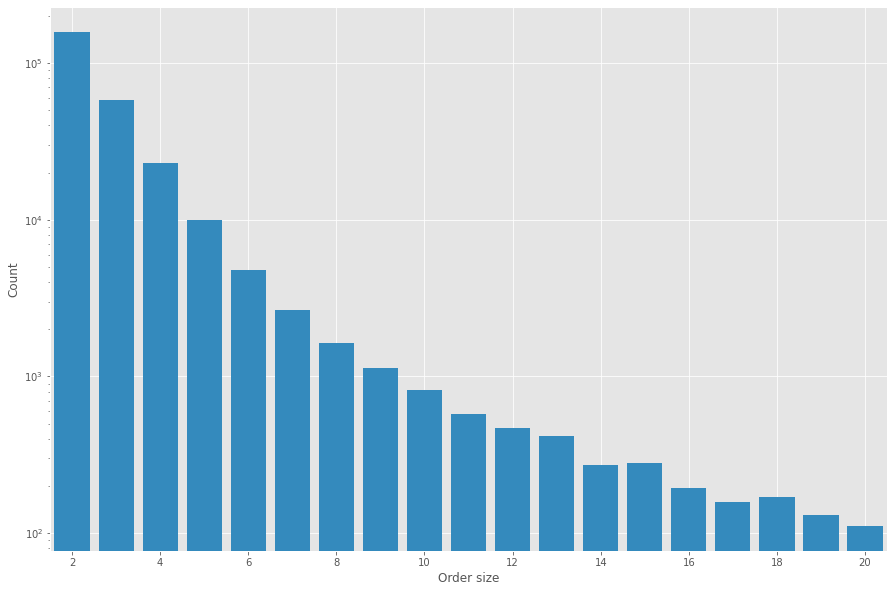

In [45]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (15,10)
plt.style.use('ggplot')
color = list(plt.rcParams['axes.prop_cycle'])[1]['color']
print(colors)

counts = [157920, 58074, 23160, 9934, 4783, 2653, 1638, 1131, 822, 572, 466, 415, 272, 279, 194, 157, 169, 131, 111]
f = plt.figure()
plt.bar(np.arange(2, 21), counts, log=True, color=color)
plt.xlabel('Order size')
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.xlim([1.5, 20.5])
plt.ylabel('Count')

plt.savefig('../Data/order_sizes.png', dpi=400)
plt.show()

In [1]:
import logging

# create logger
logger = logging.getLogger(__name__)
# set log level for all handlers to debug
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
# best for development or debugging
consoleHandler = logging.StreamHandler()
consoleHandler.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

# add formatter to ch
consoleHandler.setFormatter(formatter)

# add ch to logger
logger.addHandler(consoleHandler)

###################
# USE LOGGER
###################

# example usage
logger.debug('debug message')
logger.info('info message')
logger.warning('warn message')
logger.error('error message')
logger.critical('critical message')

2022-05-19 15:02:48,425 - __main__ - DEBUG - debug message
2022-05-19 15:02:48,426 - __main__ - INFO - info message
2022-05-19 15:02:48,427 - __main__ - WARNING - warn message
2022-05-19 15:02:48,428 - __main__ - ERROR - error message
2022-05-19 15:02:48,429 - __main__ - CRITICAL - critical message



Distance: 75.8232
Distance: 69.9664
Distance: 68.2416
Distance: 68.1496
Distance: 64.932
Distance: 64.8128
Distance: 64.8128 x

Distance: 69.2124
Distance: 67.9896
Distance: 66.6108
Distance: 65.4872
Distance: 62.7296
Distance: 62.7332
Distance: 62.7296 x

Distance: 78.2536
Distance: 76.7752
Distance: 75.954
Distance: 74.0976
Distance: 72.6168
Distance: 72.492  x
Distance: 72.5028

Distance: 79.0908
Distance: 75.9856
Distance: 74.4748
Distance: 73.7268
Distance: 70.7604
Distance: 70.806
Distance: 70.7536 x

Freq baseline: 64.8128

Freq start:
100 gen: 71.554
500 gen: 96.444


EAR baseline:

EAR start:


# TEST!

In [37]:
d1, d2, d3 = pp.train_val_test_split(data_path='../Data/USE_FIRST_train_data_dec_feb.csv', 
                                                       val_prop=0.25, test_prop=0.25, 
                                                       n_orders=10000000)

train_data = pd.concat([d1, d2, d3], ignore_index=True, axis=0) 


d1, d2, d3 = pp.train_val_test_split(data_path='../Data/test_data_dec_to_jan.csv', 
                                                       val_prop=0.25, test_prop=0.25, 
                                                       n_orders=10000000)

test_data = pd.concat([d1, d2, d3], ignore_index=True, axis=0) 


                                
                         

train_data = pp.preprocess_data(train_data)
# val_data = pp.preprocess_data(val_data)
test_data = pp.preprocess_data(test_data)

# data_df = pd.concat([train_data, val_data], ignore_index=True, axis=0)

train_orders = pp.unique_orders(train_data)
# val_orders = pp.unique_orders(val_data)
test_orders = pp.unique_orders(test_data)

train_unique = list(train_data['ArticleName'].unique())
# val_unique = list(val_data['ArticleName'].unique())
# test_unique = list(test_data['ArticleName'].unique())

all_unique = pd.concat([train_data, test_data], ignore_index=True, axis=0)['ArticleName'].unique() 

train_df, train_supports = get_arm_data(train_orders, list(all_unique))
test_df, _ = get_arm_data(test_orders, list(all_unique))



test_df = test_df.reindex(train_df.columns, axis=1)

article_list_ordered = list(train_df.columns)

# article_list_ordered = []
# for a in train_df.columns:
#     if a in data_df['ArticleName'].unique():
#         article_list_ordered.append(a)

vectorizer = pp.Vectorizer(article_list_ordered)

# X_train = vectorizer.vectorize_data(train_orders, num_negative_samples=1)
# X_val = vectorizer.vectorize_data(val_orders, num_negative_samples=1)
# X_test = vectorizer.vectorize_data(test_orders, num_negative_samples=1)

# article_names, article_vecs = vectorizer.get_articles_for_embedding(test_unique)

bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_EARLY.pkl')


# print(len(article_names))

relevant_data = [train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer]
f = open(f'../../Test code/Data/final_early_data.pkl', "wb")
pickle.dump(relevant_data, f)
f.close()

15106
[258, 1285, 4014, 4825, 5367]


In [26]:
f = open(f'../Data/final_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL.pkl')

# Baselines

In [38]:
f = open(f'../Data/final_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL.pkl')

In [11]:
random_supports = train_supports.copy()
for article in random_supports.keys():
    random_supports[article] = np.random.rand()


In [12]:
# RANDOM BASELINE
random_results = []
for _ in range(5):
    for article in random_supports.keys():
        random_supports[article] = np.random.rand()
    train_articles = create_articles(random_supports, ar_weight=0, ear_weight=0, nn_weight=0)

    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=1, rule_weight=0, rule_weight_for_article_scores=0, penalty_weight=0, verbose=False, hp_tuning=False)

    average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
    random_results.append(average_distance_travelled)
print(f'{np.mean(random_results)} +- {np.std(random_results)}')

59062it [12:41, 77.54it/s] 
59062it [09:58, 98.75it/s] 
59062it [10:22, 94.89it/s] 
59062it [09:55, 99.10it/s] 
59062it [09:46, 100.62it/s]

114.82247807388846 +- 0.6267975745641963


In [34]:
## IN ORDER BASELINE
train_articles = create_articles(train_supports, ar_weight=0, ear_weight=0, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=1, rule_weight=0, rule_weight_for_article_scores=0, penalty_weight=0, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Baseline:', average_distance_travelled)



59062it [15:25, 63.81it/s] 

Baseline: 48.15058751820121


In [13]:
f = open(f'../Data/final_early_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_EARLY.pkl')

In [14]:
random_supports = train_supports.copy()
for article in random_supports.keys():
    random_supports[article] = np.random.rand()


In [15]:
# RANDOM BASELINE
random_results = []
for _ in range(5):
    for article in random_supports.keys():
        random_supports[article] = np.random.rand()
    train_articles = create_articles(random_supports, ar_weight=0, ear_weight=0, nn_weight=0)

    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=1, rule_weight=0, rule_weight_for_article_scores=0, penalty_weight=0, verbose=False, hp_tuning=False)

    average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
    random_results.append(average_distance_travelled)
print(f'{np.mean(random_results)} +- {np.std(random_results)}')

59062it [10:11, 96.59it/s] 
3615it [00:39, 91.48it/s] 


KeyboardInterrupt: 

In [36]:
## IN ORDER BASELINE
train_articles = create_articles(train_supports, ar_weight=0, ear_weight=0, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=1, rule_weight=0, rule_weight_for_article_scores=0, penalty_weight=0, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Baseline:', average_distance_travelled)

59062it [16:21, 60.17it/s] 

Baseline: 71.40577698012258


In [ ]:
f = open(f'../Data/final_full_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_FULL.pkl')

In [ ]:
random_supports = train_supports.copy()
for article in random_supports.keys():
    random_supports[article] = np.random.rand()


In [ ]:
# RANDOM BASELINE
random_results = []
for _ in range(5):
    for article in random_supports.keys():
        random_supports[article] = np.random.rand()
    train_articles = create_articles(random_supports, ar_weight=0, ear_weight=0, nn_weight=0)

    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=1, rule_weight=0, rule_weight_for_article_scores=0, penalty_weight=0, verbose=False, hp_tuning=False)

    average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
    random_results.append(average_distance_travelled)
print(f'{np.mean(random_results)} +- {np.std(random_results)}')

In [38]:
## IN ORDER BASELINE
train_articles = create_articles(train_supports, ar_weight=0, ear_weight=0, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=1, rule_weight=0, rule_weight_for_article_scores=0, penalty_weight=0, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Baseline:', average_distance_travelled)

59062it [17:32, 56.11it/s] 

Baseline: 54.232501439165624


# Genetic tests

Warm start by frequency


100%|██████████| 100/100 [18:17<00:00, 10.97s/it]


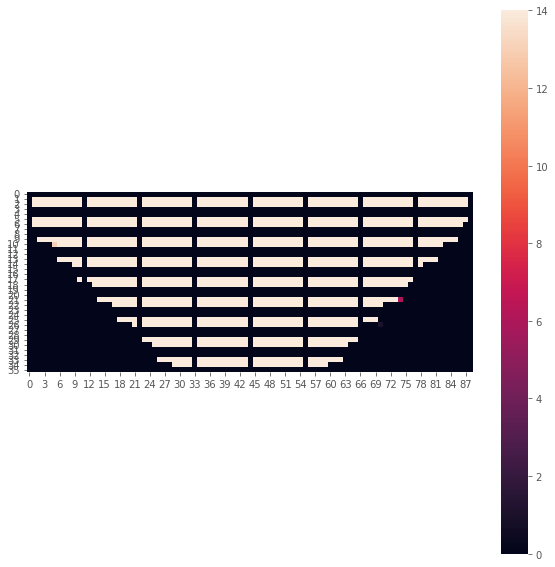

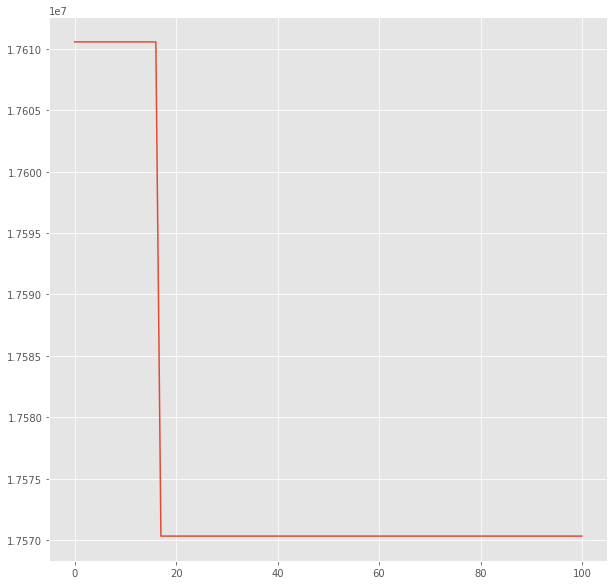

59062it [15:03, 65.38it/s] 

Result: 53.41617283532559


In [33]:
# AR results!
dw = 1e5
rw = 1
# dw = 1
# rw = 0


itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')


train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
solution = run_genetic(articles=train_articles,
                layout=layout, 
                distance_weight=dw,
                rule_weight=rw, 
                population_size=100, 
                n_iter=100, 
                crossover_rate=100, 
                mutation_rate=0.001, 
                k_selection=3, 
                crossover='crossover_height', 
                fitness='fitness_distance_and_rules', 
                orders=None, 
                warm_start=True, 
                parallel=False,
                verbose=1,
                solution=None)



                
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)


In [46]:
# Unweighted EAR results!
dw = 1e6
rw = 1e-2 # Tror det kan balla ur med för stor dw så sänker denna ist



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')



parallel_weight = 1000
k = 6
r = 6



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')

words = vectorizer.cv.get_feature_names_out()

ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_unweeighted_FINAL.pkl', 
                            word_weights=np.ones_like(words), 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 


train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_genetic(articles=train_articles,
                layout=layout, 
                distance_weight=dw,
                rule_weight=rw, 
                population_size=100, 
                n_iter=5, 
                crossover_rate=100, 
                mutation_rate=0.001, 
                k_selection=3, 
                crossover='crossover_height', 
                fitness='fitness_distance_and_rules', 
                orders=None, 
                warm_start=True, 
                parallel=False,
                verbose=1,
                solution=None)



                
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)


Warm start by frequency


 80%|████████  | 4/5 [00:45<00:11, 11.28s/it]

In [ ]:
# EAR results!
dw = 1e7
rw = 1

gamma = 1.6
delta = 3.5
parallel_weight = 10
k = 2
r = 1



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')

words = vectorizer.cv.get_feature_names_out()
word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                            train_orders, 
                                                                            words, 
                                                                            gamma=gamma,
                                                                            delta=delta)
                                                                            
min_score = np.min([score for score in word_scores if score > 0])
word_scores = [score if score > 0 else min_score/2 for score in word_scores]
ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_FINAL.pkl', 
                            word_weights=word_scores, 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 


train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_genetic(articles=train_articles,
                layout=layout, 
                distance_weight=dw,
                rule_weight=rw, 
                population_size=100, 
                n_iter=5, 
                crossover_rate=100, 
                mutation_rate=0.001, 
                k_selection=3, 
                crossover='crossover_height', 
                fitness='fitness_distance_and_rules', 
                orders=None, 
                warm_start=True, 
                parallel=False,
                verbose=1,
                solution=None)



                
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)


In [16]:
# NNR results!
dw = 1e6
rw = 1

f = open('../Data/nn_rules_sep_nov.pkl', 'rb')
nn_rules = pickle.load(f)
f.close()



train_articles = create_articles(train_supports, nn_rules=nn_rules, ar_weight=0, ear_weight=0, nn_weight=1)
solution = run_genetic(articles=train_articles,
                layout=layout, 
                distance_weight=dw,
                rule_weight=rw, 
                population_size=100, 
                n_iter=5000, 
                crossover_rate=100, 
                mutation_rate=0.001, 
                k_selection=3, 
                crossover='crossover_height', 
                fitness='fitness_distance_and_rules', 
                orders=None, 
                warm_start=True, 
                parallel=False,
                verbose=1,
                solution=None)



                
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)


Warm start by frequency


  6%|▌         | 298/5000 [14:21:57<226:40:21, 173.55s/it]


KeyboardInterrupt: 

In [ ]:
# All rules results!
dw = 5e7
rw = 1

gamma = 1.6
delta = 3.5
parallel_weight = 10
k = 2
r = 1

ear_weight = 1e-4
nn_weight = 10



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')

words = vectorizer.cv.get_feature_names_out()
word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                            train_orders, 
                                                                            words, 
                                                                            gamma=gamma,
                                                                            delta=delta)
                                                                            
min_score = np.min([score for score in word_scores if score > 0])
word_scores = [score if score > 0 else min_score/2 for score in word_scores]
ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL.pkl', 
                            save_path=f'../Test code/Data/Rules/ear_rules_pair_scores_FINAL.pkl', 
                            word_weights=word_scores, 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 


f = open('../Data/nn_rules_sep_nov.pkl', 'rb')
nn_rules = pickle.load(f)
f.close()



train_articles = create_articles(train_supports, ar_rules=ar_rules, ear_rules=ear_rules, nn_rules=nn_rules, ar_weight=1, ear_weight=ear_weight, nn_weight=nn_weight)
solution = run_genetic(articles=train_articles,
                layout=layout, 
                distance_weight=dw,
                rule_weight=rw, 
                population_size=100, 
                n_iter=5000, 
                crossover_rate=100, 
                mutation_rate=0.001, 
                k_selection=3, 
                crossover='crossover_height', 
                fitness='fitness_distance_and_rules', 
                orders=None, 
                warm_start=True, 
                parallel=False,
                verbose=1,
                solution=None)



                
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)


# Greedy tests

In [29]:
# EAR results!
parallel_weight = 10
gamma = 1.6
delta = 3.5
k = 2
r = 1

dw = 1e6
aw = 1e-8
p = 0

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')

words = vectorizer.cv.get_feature_names_out()
word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                            train_orders, 
                                                                            words, 
                                                                            gamma=gamma,
                                                                            delta=delta)
                                                                            
min_score = np.min([score for score in word_scores if score > 0])
word_scores = [score if score > 0 else min_score/2 for score in word_scores]
ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_FINAL.pkl', 
                            word_weights=word_scores, 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 

train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [12:08, 81.09it/s] 

Result: 46.72523788561173


In [43]:
# Unweighted EAR results!
parallel_weight = 1000

k = 6
r = 6

dw = 1e8
aw = 1
p = 1e-6

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')


ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_unweighted_FINAL.pkl', 
                            word_weights=defaultdict(lambda: 1), 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 

train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [09:48, 100.43it/s]

Result: 82.45450543496665


In [44]:
# AR results!
dw = 5e4
aw = 1
p = 1e-6

scores = defaultdict(list)



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')


train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)


59062it [09:40, 101.82it/s]

Result: 86.920727371237


In [53]:
# AR + EAR results!
# parallel_weight = 10
# gamma = 1.6
# delta = 3.5
# k = 2
# r = 1

# dw = 5e4
# aw = 1
# p = 1e-6

# scores = defaultdict(list)
# # score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



# itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

# ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
#                             save_path=f'../Data/Rules/ar_rules_FINAL_FULL.pkl')

# words = vectorizer.cv.get_feature_names_out()
# word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
#                                                                             train_orders, 
#                                                                             words, 
#                                                                             gamma=gamma,
#                                                                             delta=delta)
                                                                            
# min_score = np.min([score for score in word_scores if score > 0])
# word_scores = [score if score > 0 else min_score/2 for score in word_scores]
# ear_rules = get_ear_rules(ar_rules, 
#                             unique_items=list(all_unique),
#                             k=k,
#                             r=r, 
#                             embeddings_path=f'../Data/sparse_bow_FINAL_FULL.pkl', 
#                             save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_FINAL_FULL.pkl', 
#                             word_weights=word_scores, 
#                             is_sparse=True,
#                             beta=r/10,
#                             parallel_rules=True,
#                             parallel_weight=parallel_weight) 


# train_articles = create_articles(train_supports, ar_rules=ar_rules, ear_rules=ear_rules, ar_weight=1, ear_weight=0.01, nn_weight=0)
# solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
# average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
# print('Result:', average_distance_travelled)

KeyError: 'apple strömadapter usbc 18w vit'

In [15]:
# 1, 1e-4, 10
# All rules together

parallel_weight = 10
gamma = 1.6
delta = 3.5
k = 2
r = 1

ear_weight = 1e-4
nn_weight = 10

dw = 5e5
aw = 1
p = 1e-6

scores = defaultdict(list)



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL_FULL.pkl')

words = vectorizer.cv.get_feature_names_out()
word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                            train_orders, 
                                                                            words, 
                                                                            gamma=gamma,
                                                                            delta=delta)
                                                                            
min_score = np.min([score for score in word_scores if score > 0])
word_scores = [score if score > 0 else min_score/2 for score in word_scores]
ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL_FULL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_FINAL_FULL.pkl', 
                            word_weights=word_scores, 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 


f = open('../Data/nn_rules_sep_nov.pkl', 'rb')
nn_rules = pickle.load(f)
f.close()

train_articles = create_articles(train_supports, ar_rules=ar_rules, ear_rules=ear_rules, nn_rules=nn_rules, ar_weight=1, ear_weight=ear_weight, nn_weight=nn_weight)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [12:56, 76.05it/s] 

Result: 61.30100572279977


In [21]:
# itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.00001)

# ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
#                             save_path=f'../Data/Rules/ar_rules_dummy.pkl')

# # words = vectorizer.cv.get_feature_names_out()
# # word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
# #                                                                             train_orders, 
# #                                                                             words, 
# #                                                                             gamma=gamma,
# #                                                                             delta=delta)
                                                                            
# # min_score = np.min([score for score in word_scores if score > 0])
# # word_scores = [score if score > 0 else min_score/2 for score in word_scores]
# ear_rules = get_ear_rules(ar_rules, 
#                             unique_items=list(all_unique),
#                             k=k,
#                             r=r, 
#                             embeddings_path=f'../Data/sparse_bow_dummy.pkl', 
#                             save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_dummy_3.pkl', 
#                             word_weights=word_scores, 
#                             is_sparse=True,
#                             beta=r/10,
#                             parallel_rules=True,
#                             parallel_weight=parallel_weight) 


# HP testing

In [14]:
def run_unweighted(data, cv_index):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    start = time.time()
    itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

    # f = open(f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl', "rb")
    # ar_rules = pickle.load(f)
    # f.close()

    
    train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
    ar_result = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1, verbose=True)
                                                                                
    print('AR result: ', ar_result)
    words = vectorizer.cv.get_feature_names_out()
    k = 4
    ear_rules = get_ear_rules(ar_rules, 
                                unique_items=list(all_unique),
                                k=k,
                                r=100,
                                embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                save_path=f'../../Test code/Data/Rules/ear_rules_unweighted_cv{cv_index}.pkl', 
                                word_weights=np.ones_like(words), 
                                is_sparse=True,
                                beta=1)

    train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
    average_distance_travelled = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1)
    print(average_distance_travelled)

    

In [15]:
def run_parallel_rules(data, cv_index):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    start = time.time()
    itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

    # f = open(f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl', "rb")
    # ar_rules = pickle.load(f)
    # f.close()

    
    train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
    ar_result = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1, verbose=True)
                                                                                
    print('AR result: ', ar_result)
    words = vectorizer.cv.get_feature_names_out()
    k = 4
    ear_rules = get_ear_rules(ar_rules, 
                                unique_items=list(all_unique),
                                k=k,
                                r=100,
                                embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                save_path=f'../../Test code/Data/Rules/ear_rules_parallel_rules2_cv{cv_index}.pkl', 
                                word_weights=np.ones_like(words), 
                                is_sparse=True,
                                beta=1,
                                parallel_rules=True,
                                )

    train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
    average_distance_travelled = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1)
    print(average_distance_travelled)


In [16]:
n_orders=20000
def test_hyperparameters(data, cv_index, parallel_rules=False, ks=[], rs=[]):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

    # f = open(f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl', "rb")
    # ar_rules = pickle.load(f)
    # f.close()



    results = np.zeros((len(ks), len(rs)))
    for i, k in enumerate(ks):
        for j, r in enumerate(rs):

            ear_rules = get_ear_rules(ar_rules, 
                                    unique_items=list(all_unique),
                                    k=k,
                                    r=r, 
                                    embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                    save_path=f'../../Test code/Data/Rules/ear_rules_k{k}_r{r}_unweighted_cv{cv_index}_parallel_{parallel_rules}.pkl', 
                                    word_weights=defaultdict(lambda: 1), 
                                    is_sparse=True,
                                    beta=r/10,
                                    parallel_rules=parallel_rules)

            train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
            solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
            average_distance_travelled = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1)

            results[i,j] = average_distance_travelled

    results = pd.DataFrame(results, index=ks)

    col_names = {i: delta for i, delta in enumerate(rs)}
    results.rename(columns=col_names, inplace=True)
    print('Results:')
    print(results)

    results.to_excel(f'../Data/Results/ks{ks}rs{rs}_cv{cv_index}.xlsx')

In [17]:
def test_hyperparameters_pair_scores(data, cv_index, parallel_rules=False, deltas=[], gammas=[]):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    start = time.time()
    itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

    # f = open(f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl', "rb")
    # ar_rules = pickle.load(f)
    # f.close()


    if not parallel_rules:
        results = np.zeros((len(gammas), len(deltas)))
        for i, gamma in enumerate(gammas):
            for j, delta in enumerate(deltas):

                words = vectorizer.cv.get_feature_names_out()
                word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                                          train_orders, 
                                                                                          words, 
                                                                                          gamma=gamma,
                                                                                          delta=delta)
                
                min_score = np.min([score for score in word_scores if score > 0])
                word_scores = [score if score > 0 else min_score/2 for score in word_scores]

                ear_rules = get_ear_rules(ar_rules, 
                                            unique_items=list(all_unique),
                                            k=k, 
                                            embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                            save_path=f'../../Test code/Data/Rules/ear_rules_good_pair_scores_k{k}_gamma{gamma}_delta{delta}_cv{cv_index}.pkl', 
                                            word_weights=word_scores, 
                                            is_sparse=True,
                                            beta=beta) 

                train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
                solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
                average_distance_travelled = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1)

                results[i,j] = average_distance_travelled

        results = pd.DataFrame(results, index=gammas)

        col_names = {i: delta for i, delta in enumerate(deltas)}
        results.rename(columns=col_names, inplace=True)
        print('Results:')
        print(results)

        results.to_excel(f'../Data/Results/ear_good_pair_scores_gamma{gammas}_delta{deltas}_k{4}_cv{cv_index}.xlsx')


In [18]:
def test_hyperparameters_k_r(data, cv_index, parallel_rules=False, ks=[], rs=[], gamma=0.75, delta=1.75):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    start = time.time()
    itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

    # f = open(f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl', "rb")
    # ar_rules = pickle.load(f)
    # f.close()


    train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
    ar_result = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1, verbose=True)

    words = vectorizer.cv.get_feature_names_out()
    word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                                train_orders, 
                                                                                words, 
                                                                                gamma=gamma,
                                                                                delta=delta)
                                                                                
    min_score = np.min([score for score in word_scores if score > 0])
    word_scores = [score if score > 0 else min_score/2 for score in word_scores]

    print('AR result: ', ar_result)
    if not parallel_rules:
        results = np.zeros((len(ks), len(rs)))
        for i, k in enumerate(ks):
            for j, r in enumerate(rs):

                ear_rules = get_ear_rules(ar_rules, 
                                            unique_items=list(all_unique),
                                            k=k,
                                            r=r, 
                                            embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                            save_path=f'../../Test code/Data/Rules/ear_rules_single_scores_k{k}_r{r}_cv{cv_index}_xx.pkl', 
                                            word_weights=word_scores, 
                                            is_sparse=True,
                                            beta=r/10) 

                train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
                solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
                average_distance_travelled = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1)

                results[i,j] = average_distance_travelled

        results = pd.DataFrame(results, index=ks)

        col_names = {i: r for i, r in enumerate(rs)}
        results.rename(columns=col_names, inplace=True)
        print('Results:')
        print(results)

        results.to_excel(f'../Data/Results/ear_k{ks}_r{rs}_k{4}_cv{cv_index}.xlsx')

In [19]:
def test_hyperparameters_parallel(data, cv_index, parallel_rules=False, parallel_weights=[], k=[], r=[], gamma=0.75, delta=1.75):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    start = time.time()
    itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

    # f = open(f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl', "rb")
    # ar_rules = pickle.load(f)
    # f.close()


#     train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
#     solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
#     ar_result = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1, verbose=True)

#     words = vectorizer.cv.get_feature_names_out()
#     word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
#                                                                                 train_orders, 
#                                                                                 words, 
#                                                                                 gamma=gamma,
#                                                                                 delta=delta)
                                                                                
#     min_score = np.min([score for score in word_scores if score > 0])
#     word_scores = [score if score > 0 else min_score/2 for score in word_scores]

#     print('AR result: ', ar_result)
    results = np.zeros((len(parallel_weights)))
    for i, parallel_weight in enumerate(parallel_weights):
            ear_rules = get_ear_rules(ar_rules, 
                                        unique_items=list(all_unique),
                                        k=k,
                                        r=r, 
                                        embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                        save_path=f'../../Test code/Data/Rules/ear_rules_unweighted_k{k}_r{r}_cv{cv_index}_parallel{parallel_weight}.pkl', 
                                        word_weights=defaultdict(lambda: 1), 
                                        is_sparse=True,
                                        beta=r/10,
                                        parallel_rules=parallel_rules,
                                        parallel_weight=parallel_weight) 

            train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
            solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
            average_distance_travelled = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1)

            results[i] = average_distance_travelled

    print('Results:')
    print(results)
    results = pd.DataFrame(results, index=parallel_weights)

    # col_names = {i: r for i, r in enumerate(rs)}
    # results.rename(columns=col_names, inplace=True)
    

    results.to_excel(f'../Data/Results/ear_k_parallel{parallel_weights}_cv{cv_index}.xlsx')

In [20]:
def test_hyperparameters_ar_ear(data, cv_index, parallel_rules=True, parallel_weight=10, k=2, r=1, gamma=1.6, delta=3.5, ear_weights=[]):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    start = time.time()
    itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')



    words = vectorizer.cv.get_feature_names_out()
    word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                                train_orders, 
                                                                                words, 
                                                                                gamma=gamma,
                                                                                delta=delta)
                                                                                
    min_score = np.min([score for score in word_scores if score > 0])
    word_scores = [score if score > 0 else min_score/2 for score in word_scores]

    results = np.zeros((len(ear_weights)))
    
    ear_rules = get_ear_rules(ar_rules, 
                                unique_items=list(all_unique),
                                k=k,
                                r=r, 
                                embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_comb_k{k}_r{r}_cv{cv_index}_parallel{parallel_weight}.pkl', 
                                word_weights=word_scores, 
                                is_sparse=True,
                                beta=r/10,
                                parallel_rules=parallel_rules,
                                parallel_weight=parallel_weight) 

    for i, ear_weight in enumerate(ear_weights):

        train_articles = create_articles(train_supports, ar_rules=ar_rules, ear_rules=ear_rules, ar_weight=1, ear_weight=ear_weight, nn_weight=0)
        solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
        average_distance_travelled = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1)

        results[i] = average_distance_travelled

    print('Results:')
    print(results)
    results = pd.DataFrame(results, index=ear_weights)

    # col_names = {i: r for i, r in enumerate(rs)}
    # results.rename(columns=col_names, inplace=True)
    

    results.to_excel(f'../Data/Results/ear_weights{ear_weights}_cv{cv_index}.xlsx')

In [21]:
def test_hyperparameters_rule_type(data, cv_index, parallel_rules=True, parallel_weight=10, k=2, r=1, gamma=1.6, delta=3.5, ear_weights=[], nn_weights=[]):
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    _, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')



    words = vectorizer.cv.get_feature_names_out()
    word_scores, _, _ = calculate_word_scores(train_unique, 
                                                                                train_orders, 
                                                                                words, 
                                                                                gamma=gamma,
                                                                                delta=delta)
                                                                                
    min_score = np.min([score for score in word_scores if score > 0])
    word_scores = [score if score > 0 else min_score/2 for score in word_scores]

    results = np.zeros((len(ear_weights), len(nn_weights)))
    
    ear_rules = get_ear_rules(ar_rules, 
                                unique_items=list(all_unique),
                                k=k,
                                r=r, 
                                embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_combined_k{k}_r{r}_cv{cv_index}_parallel{parallel_weight}.pkl', 
                                word_weights=word_scores, 
                                is_sparse=True,
                                beta=r/10,
                                parallel_rules=parallel_rules,
                                parallel_weight=parallel_weight) 

    f = open(f'../Data/HP/nn_rules_f_{cv_index}_k_100_r_0.001.pkl', 'rb')
    nn_rules = pickle.load(f)
    f.close()

    for i, ear_weight in tqdm(enumerate(ear_weights)):
        for j, nn_weight in enumerate(nn_weights):

            train_articles = create_articles(train_supports, ar_rules=ar_rules, ear_rules=ear_rules, nn_rules=nn_rules, ar_weight=1, ear_weight=ear_weight, nn_weight=nn_weight)
            solution = run_greedy(articles=train_articles, layout=layout, distance_weight=0, rule_weight=1, rule_weight_for_article_scores=1, penalty_weight=0, verbose=False, hp_tuning=True)
            average_distance_travelled = evaluate_solution_for_greedy_no_depot(solution, test_df, layout, batch_size=1)

            results[i, j] = average_distance_travelled

    print('Results:')
    print(results)
    results = pd.DataFrame(results, index=ear_weights)

    col_names = {i: r for i, r in enumerate(nn_weights)}
    results.rename(columns=col_names, inplace=True)
    

    results.to_excel(f'../Data/Results/ear_weights{ear_weights}_nn_weights{nn_weights}_cv{cv_index}_2.xlsx')

In [22]:
## Large tuning¨
# Stig som djunglar

# load data somehow
# (data, cv_index, parallel_rules=False, parallel_weights=[], k=[], r=[], gamma=0.75, delta=1.75):



In [ ]:
# ear_weights = [1e-4, 1e-3, 1e-2, 1e-1, 1]
# nn_weights = [1e-1, 1, 1e1, 1e2]

# for cv_index in range(4):
#     try:
#         data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
#         train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
#         bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
#     except:
#         data = create_data(cv_index)
#     # train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
#     # run_unweighted(data, cv_index)

#     test_hyperparameters_rule_type(data, cv_index, ear_weights=ear_weights, nn_weights=nn_weights)
    

# Small layout

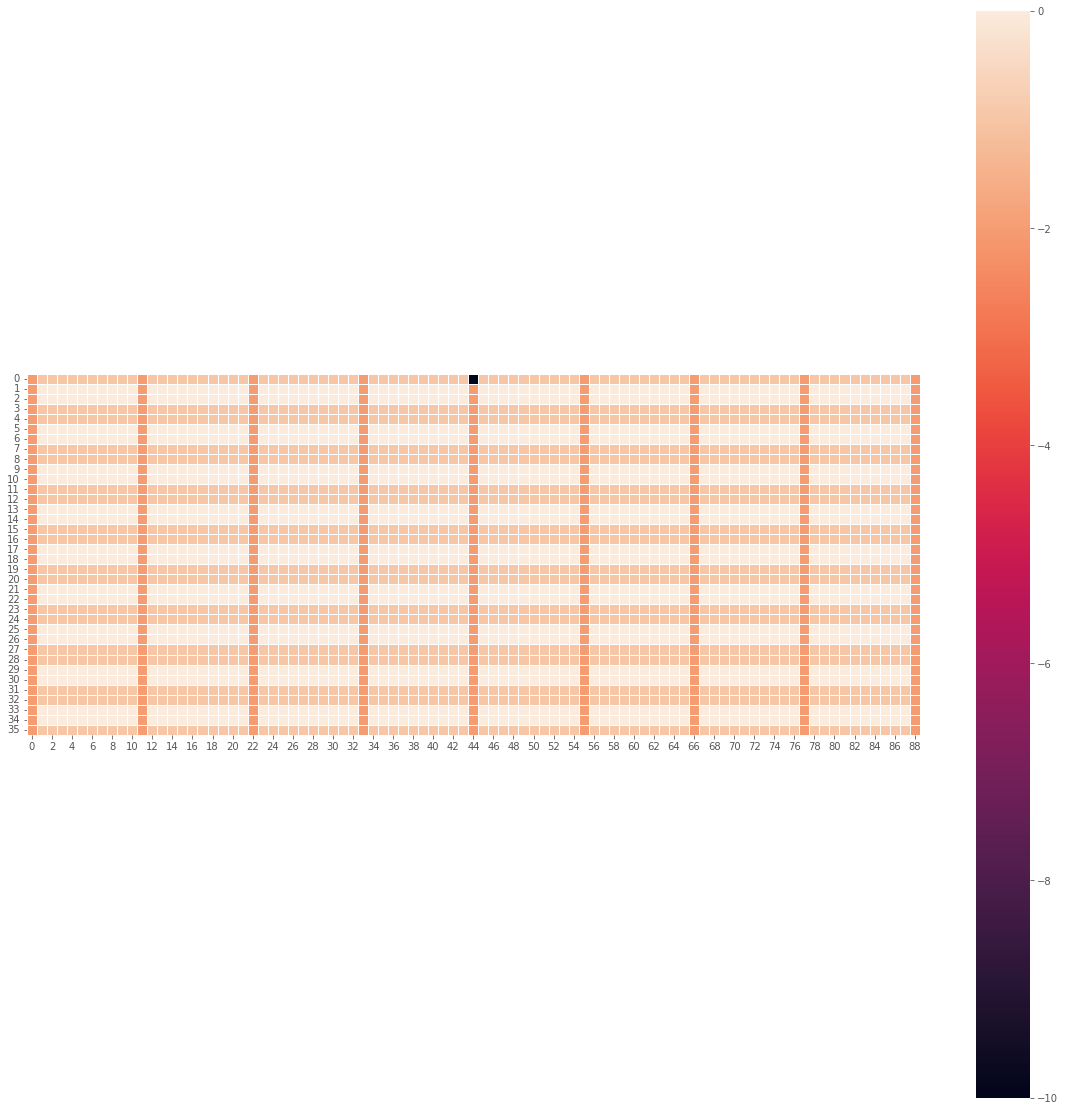

In [7]:
n_orders = 20000

layout_file = open('../Data/HP/layout_big.pkl', "rb")
layout = pickle.load(layout_file)
layout_file.close()


plt.figure(figsize=(20,20))
sns.heatmap(layout.layout_matrix, square=True, linewidths=1)
plt.show() 
for shelf in layout.shelves:
    shelf.height = 5
    
layout.shelves.sort(key=lambda x: layout.distances[layout.depot_location][x.pick_location])

layout.find_shelves_closest_to_depot()


# EAR Tuning

In [10]:
parallel_weight = 10
gamma = 1.6
delta = 3.5
k = 2
r = 1

ear_weight = 1e-4
nn_weight = 10

ar_weight = 0
ear_weight = 1
nn_weight = 0

dw = 5e5
aw = 1
p = 0


dws = [1e5, 1e6, 1e7]
aws = [1e-9, 1e-8, 1e-7]
# dws = [1e6]
# aws = [1e-8]
all_results = []
for cv_index in range(4):
    try:
        data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
        bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
    except:
        data = create_data(cv_index)
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    _, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')



    words = vectorizer.cv.get_feature_names_out()
    word_scores, _, _ = calculate_word_scores(train_unique, 
                                                train_orders, 
                                                words, 
                                                gamma=gamma,
                                                delta=delta)
                                                                                
    min_score = np.min([score for score in word_scores if score > 0])
    word_scores = [score if score > 0 else min_score/2 for score in word_scores]

    results = np.zeros((len(dws), len(aws)))

    ear_rules = get_ear_rules(ar_rules, 
                                unique_items=list(all_unique),
                                k=k,
                                r=r, 
                                embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_combined_k{k}_r{r}_cv{cv_index}_parallel{parallel_weight}.pkl', 
                                word_weights=word_scores, 
                                is_sparse=True,
                                beta=r/10,
                                parallel_rules=True,
                                parallel_weight=parallel_weight) 

    f = open(f'../Data/HP/nn_rules_f_{cv_index}_k_100_r_0.001.pkl', 'rb')
    nn_rules = pickle.load(f)
    f.close()

    for i, dw in tqdm(enumerate(dws)):
        for j, aw in enumerate(aws):

            train_articles = create_articles(train_supports, ar_rules=ar_rules, ear_rules=ear_rules, nn_rules=nn_rules, ar_weight=ar_weight, ear_weight=ear_weight, nn_weight=nn_weight)
            solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
            average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1)

            results[i, j] = average_distance_travelled

    print('Results:')
    print(results)
    all_results.append(results)
    # results = pd.DataFrame(results, index=dws)



3it [05:26, 108.86s/it]


Results:
[[62.9276 62.758  63.7808]
 [62.7808 62.8236 63.5728]
 [63.1868 62.8632 64.9352]]


3it [04:22, 87.63s/it]


Results:
[[61.0516 60.986  61.46  ]
 [60.6704 61.0476 61.5468]
 [61.2996 61.2192 61.7728]]


3it [09:43, 194.49s/it]


Results:
[[71.2948 71.4876 72.0384]
 [71.458  71.544  72.098 ]
 [71.6764 71.7116 72.4148]]


3it [03:46, 75.58s/it]

Results:
[[68.7428 69.114  69.6616]
 [68.2276 68.3492 69.6984]
 [68.6836 68.7592 70.238 ]]


(3, 3)
[[66.0042 66.0864 66.7352]
 [65.7842 65.9411 66.729 ]
 [66.2116 66.1383 67.3402]]
Min:  65.7842
1000000.0 1e-09


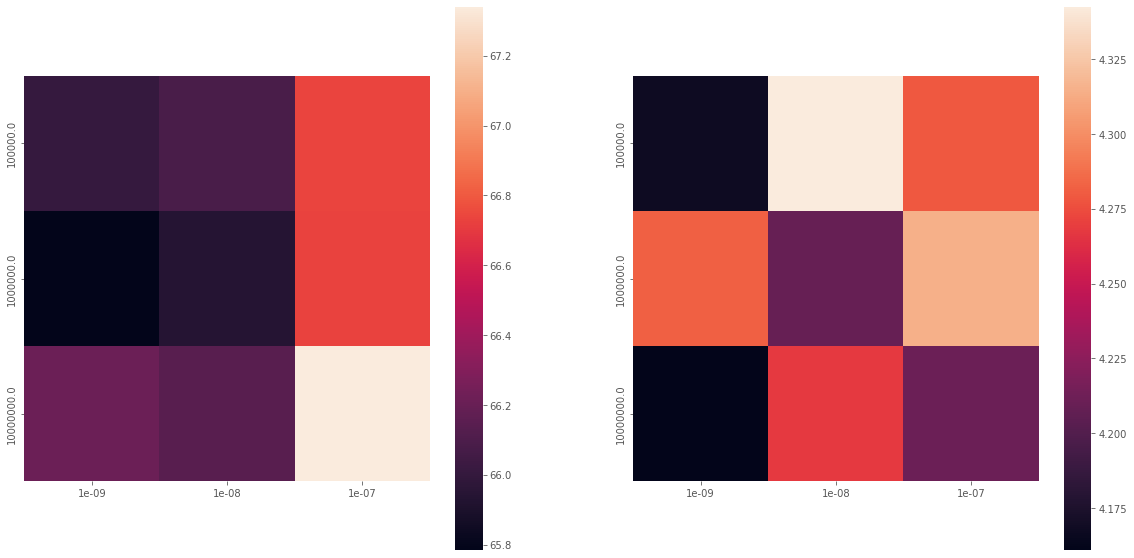

In [11]:
total_results = []
# r0 = [[50.3628, 52.8932, 52.9416, 52.9416],[50.8344, 52.4976, 52.4984, 52.4984],[46.654,  48.858,  48.8612, 48.8612], [46.4424, 47.4616, 47.4792, 47.4792],[48.8552, 49.4676 ,48.9476, 48.9476]]
# r1 = [[47.308,  50.8676, 50.9172, 50.9172],[46.872,  50.7152, 50.7152, 50.7152],[46.2428, 49.3548, 49.3548, 49.3548],[42.4292, 45.0444, 45.0432, 45.0432],[44.4548, 46.888,  46.8908, 46.8908]]
# r2 = [[58.6464, 58.0052, 57.9404, 57.9404], [51.0404, 56.0108, 56.0076, 56.0076], [48.4668, 48.9152, 48.9152, 48.9152], [48.0296, 48.5928, 48.5928, 48.5928], [49.6788, 50.4988, 50.5052, 50.5052]]
# r3 = [[50.3024, 57.786,  57.6984, 57.6984], [48.2772, 60.48,   60.48,   60.48  ], [47.0868, 51.8796, 51.9048, 51.9048], [46.4316, 46.846,  46.7772, 46.7772], [49.4408, 50.2628, 50.1344, 50.1344]]
r0, r1, r2, r3 = all_results[0], all_results[1], all_results[2], all_results[3]


dws_and_aws = []
for i, dw in enumerate(dws):
    for j, aw in enumerate(aws):
        total_results.append([r0[i][j], r1[i][j], r2[i][j], r3[i][j]])
        dws_and_aws.append((dw, aw))


res = np.reshape(np.array(total_results), newshape=(len(r0), len(r0[0]), 4))

means = np.reshape(np.mean(res, axis=2), newshape=(len(r0), len(r0[0])))
print(means.shape)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True, yticklabels=dws, xticklabels=aws)
stds = np.reshape(np.std(res, axis=2), newshape=(len(r0), len(r0[0])))
sns.heatmap(stds, ax=axes[1], square=True, yticklabels=dws, xticklabels=aws)
print(means)

print('Min: ', np.min(means))
min_index = np.argmin(means)
dw_ear, aw_ear = dws_and_aws[min_index]
print(dw_ear, aw_ear)

# FINAL EAR TESTS

In [8]:
n_orders = 20000

layout_file = open('../Data/HP/layout_big.pkl', "rb")
layout = pickle.load(layout_file)
layout_file.close()

for shelf in layout.shelves:
    shelf.height = 14
    
layout.shelves.sort(key=lambda x: layout.distances[layout.depot_location][x.pick_location])

layout.find_shelves_closest_to_depot()

In [9]:
f = open(f'../Data/final_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL.pkl')

In [10]:
# EAR results!

dw_ear = 1000000.0
aw_ear = 1e-09
parallel_weight = 10
gamma = 1.6
delta = 3.5
k = 2
r = 1

dw = dw_ear
aw = aw_ear
p = 0

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')

words = vectorizer.cv.get_feature_names_out()
word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                            train_orders, 
                                                                            words, 
                                                                            gamma=gamma,
                                                                            delta=delta)
                                                                            
min_score = np.min([score for score in word_scores if score > 0])
word_scores = [score if score > 0 else min_score/2 for score in word_scores]
ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_FINAL.pkl', 
                            word_weights=word_scores, 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 

train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [11:19, 86.96it/s] 

Result: 46.71816057702076


In [11]:
f = open(f'../Data/final_early_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_EARLY.pkl')

In [12]:
# EAR results!
parallel_weight = 10
gamma = 1.6
delta = 3.5
k = 2
r = 1

dw = dw_ear
aw = aw_ear
p = 0

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL_EARLY.pkl')

words = vectorizer.cv.get_feature_names_out()
word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                            train_orders, 
                                                                            words, 
                                                                            gamma=gamma,
                                                                            delta=delta)
                                                                            
min_score = np.min([score for score in word_scores if score > 0])
word_scores = [score if score > 0 else min_score/2 for score in word_scores]
ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL_EARLY.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_FINAL_EARLY.pkl', 
                            word_weights=word_scores, 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 

train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [09:51, 99.87it/s] 

Result: 70.51037892384274


In [13]:
f = open(f'../Data/final_full_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_FULL.pkl')

In [14]:
# EAR results!
parallel_weight = 10
gamma = 1.6
delta = 3.5
k = 2
r = 1

dw = dw_ear
aw = aw_ear
p = 0

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL_FULL.pkl')

words = vectorizer.cv.get_feature_names_out()
word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                            train_orders, 
                                                                            words, 
                                                                            gamma=gamma,
                                                                            delta=delta)
                                                                            
min_score = np.min([score for score in word_scores if score > 0])
word_scores = [score if score > 0 else min_score/2 for score in word_scores]
ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL_FULL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_pair_scores_FINAL_FULL.pkl', 
                            word_weights=word_scores, 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 

train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [08:53, 110.76it/s]

Result: 52.87931326402763


# Unweighted EAR Tuning

In [39]:
n_orders = 20000

layout_file = open('../Data/HP/layout_big.pkl', "rb")
layout = pickle.load(layout_file)
layout_file.close()

for shelf in layout.shelves:
    shelf.height = 5
    
layout.shelves.sort(key=lambda x: layout.distances[layout.depot_location][x.pick_location])

layout.find_shelves_closest_to_depot()

In [40]:
parallel_weight = 1000

k = 6
r = 6

ear_weight = 1e-4
nn_weight = 10

ar_weight = 0
ear_weight = 1
nn_weight = 0


p = 0


dws = [1e7, 1e8, 1e9]
aws = [1e-13, 1e-12, 1e-11]
# dws = [1e6]
# aws = [1e-8]
all_results = []
for cv_index in range(4):
    try:
        data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
        bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
    except:
        data = create_data(cv_index)
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    _, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')



    words = vectorizer.cv.get_feature_names_out()

    results = np.zeros((len(dws), len(aws)))

    ear_rules = get_ear_rules(ar_rules, 
                                unique_items=list(all_unique),
                                k=k,
                                r=r, 
                                embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                save_path=f'../../Test code/Data/Rules/ear_rules_unweeighted_k{k}_r{r}_cv{cv_index}_parallel{parallel_weight}.pkl', 
                                word_weights=np.ones_like(words), 
                                is_sparse=True,
                                beta=r/10,
                                parallel_rules=True,
                                parallel_weight=parallel_weight) 

    # f = open(f'../Data/HP/nn_rules_f_{cv_index}_k_100_r_0.001.pkl', 'rb')
    # nn_rules = pickle.load(f)
    # f.close()

    for i, dw in tqdm(enumerate(dws)):
        for j, aw in enumerate(aws):

            train_articles = create_articles(train_supports, ar_rules=ar_rules, ear_rules=ear_rules, ar_weight=ar_weight, ear_weight=ear_weight, nn_weight=nn_weight)
            solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
            average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1)

            results[i, j] = average_distance_travelled

    print('Results:')
    print(results)
    all_results.append(results)
    # results = pd.DataFrame(results, index=dws)


3it [06:34, 131.65s/it]


Results:
[[63.3764 63.3764 63.4776]
 [63.2016 63.2016 63.4356]
 [63.3228 63.3228 63.5868]]


3it [03:05, 61.92s/it]


Results:
[[61.0048 61.0048 60.882 ]
 [61.4612 61.4612 61.0212]
 [61.4188 61.4188 61.3   ]]


3it [08:14, 164.71s/it]


Results:
[[71.264  71.264  70.9788]
 [71.7524 71.7524 71.4352]
 [71.6424 71.6424 71.586 ]]


3it [04:07, 82.40s/it]

Results:
[[69.288  69.288  69.1044]
 [69.0804 69.0804 68.9712]
 [69.3872 69.3872 69.4576]]


(3, 3)
[[66.2333 66.2333 66.1107]
 [66.3739 66.3739 66.2158]
 [66.4428 66.4428 66.4826]]
Min:  66.11070000000001
10000000.0 1e-11


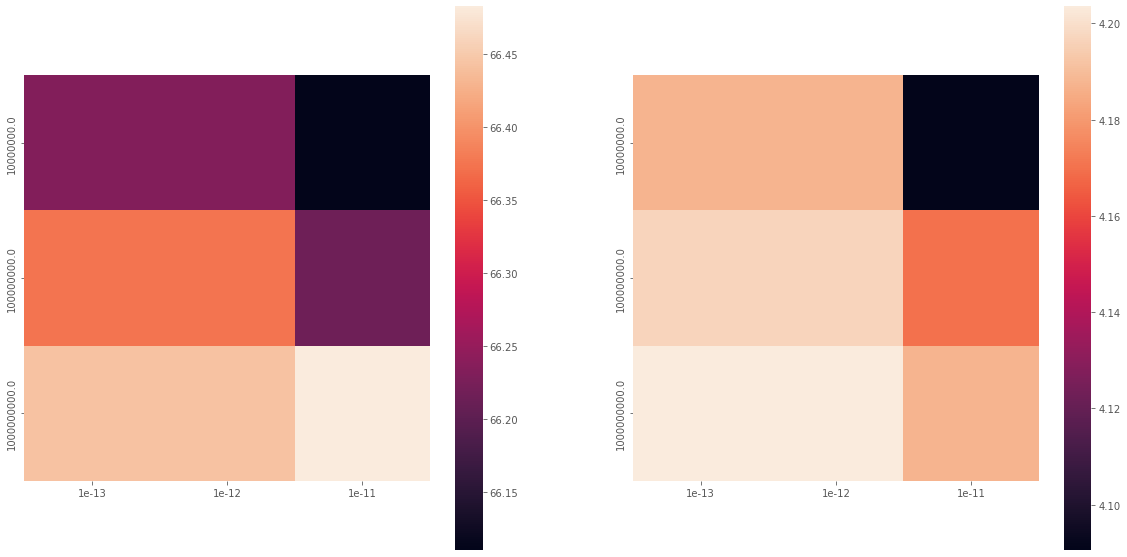

In [41]:
total_results = []
r0, r1, r2, r3 = all_results[0], all_results[1], all_results[2], all_results[3]


dws_and_aws = []
for i, dw in enumerate(dws):
    for j, aw in enumerate(aws):
        total_results.append([r0[i][j], r1[i][j], r2[i][j], r3[i][j]])
        dws_and_aws.append((dw, aw))


res = np.reshape(np.array(total_results), newshape=(len(r0), len(r0[0]), 4))

means = np.reshape(np.mean(res, axis=2), newshape=(len(r0), len(r0[0])))
print(means.shape)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True, yticklabels=dws, xticklabels=aws)
stds = np.reshape(np.std(res, axis=2), newshape=(len(r0), len(r0[0])))
sns.heatmap(stds, ax=axes[1], square=True, yticklabels=dws, xticklabels=aws)
print(means)

print('Min: ', np.min(means))
min_index = np.argmin(means)
dw_uear, aw_uear = dws_and_aws[min_index]
print(dw_uear, aw_uear)

# FINAL UEAR TESTS

In [18]:
n_orders = 20000

layout_file = open('../Data/HP/layout_big.pkl', "rb")
layout = pickle.load(layout_file)
layout_file.close()

for shelf in layout.shelves:
    shelf.height = 14
    
layout.shelves.sort(key=lambda x: layout.distances[layout.depot_location][x.pick_location])

layout.find_shelves_closest_to_depot()

In [19]:
f = open(f'../Data/final_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL.pkl')

In [20]:
parallel_weight = 1000

k = 6
r = 6

dw = dw_uear
aw = aw_uear
p = 0

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')


ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_unweighted_FINAL.pkl', 
                            word_weights=defaultdict(lambda: 1), 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 

train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [06:52, 143.13it/s]

Result: 47.32142494327994


In [21]:
f = open(f'../Data/final_early_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_EARLY.pkl')

In [22]:
parallel_weight = 1000

k = 6
r = 6

dw = dw_uear
aw = aw_uear
p = 0

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL_EARLY.pkl')


ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL_EARLY.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_unweighted_FINAL_EARLY.pkl', 
                            word_weights=defaultdict(lambda: 1), 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 

train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [07:03, 139.37it/s]

Result: 70.39064034404524


In [23]:
f = open(f'../Data/final_full_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_FULL.pkl')

In [24]:
parallel_weight = 1000

k = 6
r = 6

dw = dw_uear
aw = aw_uear
p = 0

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'



itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL_FULL.pkl')


ear_rules = get_ear_rules(ar_rules, 
                            unique_items=list(all_unique),
                            k=k,
                            r=r, 
                            embeddings_path=f'../Data/sparse_bow_FINAL_FULL.pkl', 
                            save_path=f'../../Test code/Data/Rules/ear_rules_unweighted_FINAL_FULL.pkl', 
                            word_weights=defaultdict(lambda: 1), 
                            is_sparse=True,
                            beta=r/10,
                            parallel_rules=True,
                            parallel_weight=parallel_weight) 

train_articles = create_articles(train_supports, ear_rules=ear_rules, ar_weight=0, ear_weight=1, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [14:50, 66.34it/s] 

Result: 53.27929971893942


# AR Tuning

In [7]:
n_orders = 20000

layout_file = open('../Data/HP/layout_big.pkl', "rb")
layout = pickle.load(layout_file)
layout_file.close()

for shelf in layout.shelves:
    shelf.height = 5
    
layout.shelves.sort(key=lambda x: layout.distances[layout.depot_location][x.pick_location])

layout.find_shelves_closest_to_depot()

In [16]:


ear_weight = 1e-4
nn_weight = 10

ar_weight = 1
ear_weight = 0
nn_weight = 0


p = 0


dws = [1e5]
aws = [1e-9, 1e-8, 1e-7]


results = np.zeros((len(dws), len(aws)))

all_results = []
for cv_index in range(4):
    try:
        data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
        bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
    except:
        data = create_data(cv_index)
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    _, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')




    for i, dw in tqdm(enumerate(dws)):
        for j, aw in enumerate(aws):

            train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=ar_weight, ear_weight=ear_weight, nn_weight=nn_weight)
            solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
            average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1)

            results[i, j] = average_distance_travelled

    print('Results:')
    print(results)
    all_results.append(results)
    # results = pd.DataFrame(results, index=dws)


1it [02:24, 144.51s/it]


Results:
[[37.8108 37.9076 37.9688]]


1it [01:33, 93.10s/it]


Results:
[[36.6308 36.6828 36.6616]]


1it [03:52, 232.97s/it]


Results:
[[41.9692 41.9516 41.974 ]]


1it [01:29, 89.96s/it]

Results:
[[39.7984 39.752  39.81  ]]


(1, 3)
[[39.7984 39.752  39.81  ]]
Min:  39.752
100000.0 1e-08


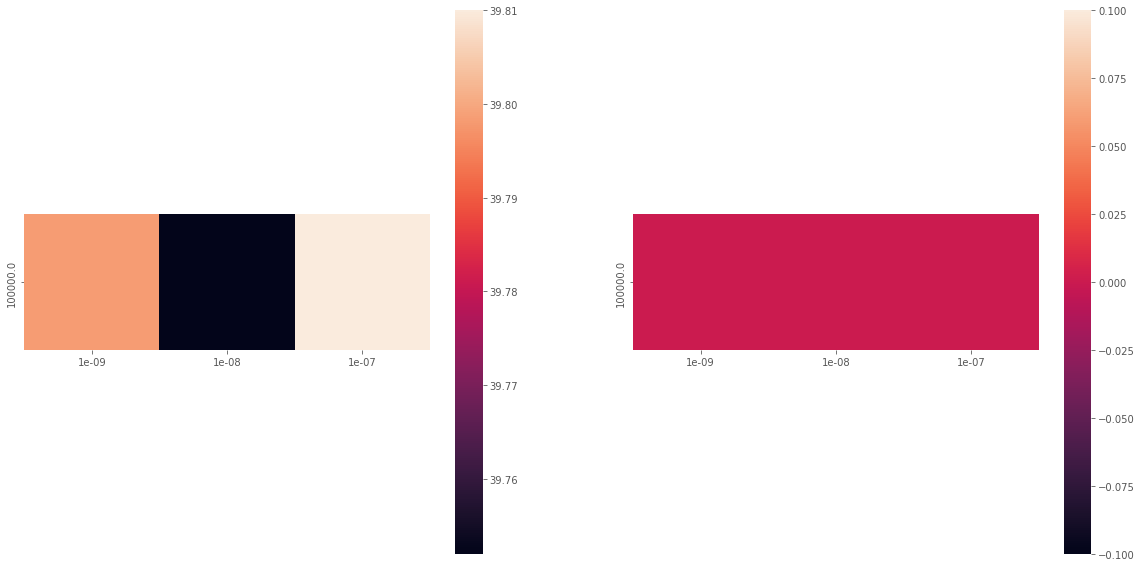

In [17]:
total_results = []
r0, r1, r2, r3 = all_results[0], all_results[1], all_results[2], all_results[3]


dws_and_aws = []
for i, dw in enumerate(dws):
    for j, aw in enumerate(aws):
        total_results.append([r0[i][j], r1[i][j], r2[i][j], r3[i][j]])
        dws_and_aws.append((dw, aw))


res = np.reshape(np.array(total_results), newshape=(len(r0), len(r0[0]), 4))

means = np.reshape(np.mean(res, axis=2), newshape=(len(r0), len(r0[0])))
print(means.shape)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True, yticklabels=dws, xticklabels=aws)
stds = np.reshape(np.std(res, axis=2), newshape=(len(r0), len(r0[0])))
sns.heatmap(stds, ax=axes[1], square=True, yticklabels=dws, xticklabels=aws)
print(means)

print('Min: ', np.min(means))
min_index = np.argmin(means)
dw_ar, aw_ar = dws_and_aws[min_index]
print(dw_ar, aw_ar)

# FINAL AR TESTS

In [18]:
n_orders = 20000

layout_file = open('../Data/HP/layout_big.pkl', "rb")
layout = pickle.load(layout_file)
layout_file.close()

for shelf in layout.shelves:
    shelf.height = 14
    
layout.shelves.sort(key=lambda x: layout.distances[layout.depot_location][x.pick_location])

layout.find_shelves_closest_to_depot()

In [19]:
f = open(f'../Data/final_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL.pkl')

In [21]:
dw_ar = 1e5
aw_ar = 1e-9
dw = dw_ar
aw = aw_ar
p = 0

_, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL.pkl')


train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [14:59, 65.65it/s] 

Result: 47.28041718871694


In [22]:
f = open(f'../Data/final_early_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_EARLY.pkl')

In [23]:

dw = dw_ar
aw = aw_ar
p = 0

_, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL_EARLY.pkl')


train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [10:44, 91.59it/s] 

Result: 70.85604957502285


In [24]:
f = open(f'../Data/final_full_data.pkl', "rb")
data = pickle.load(f)
f.close()

train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_FINAL_FULL.pkl')

In [25]:

dw = dw_ar
aw = aw_ar
p = 0

_, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                            save_path=f'../Data/Rules/ar_rules_FINAL_FULL.pkl')


train_articles = create_articles(train_supports, ar_rules=ar_rules, ar_weight=1, ear_weight=0, nn_weight=0)
solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=True)
print('Result:', average_distance_travelled)

59062it [19:27, 50.58it/s] 

Result: 53.41617283532559


# Oklart

[[56.5464 55.2531 50.8195 53.416 ]
 [55.4892 53.3755 51.423  53.3749]
 [57.6814 54.9511 54.4302 54.173 ]
 [57.5447 57.3671 56.4885 52.589 ]
 [57.0387 57.491  56.3855 52.8524]]


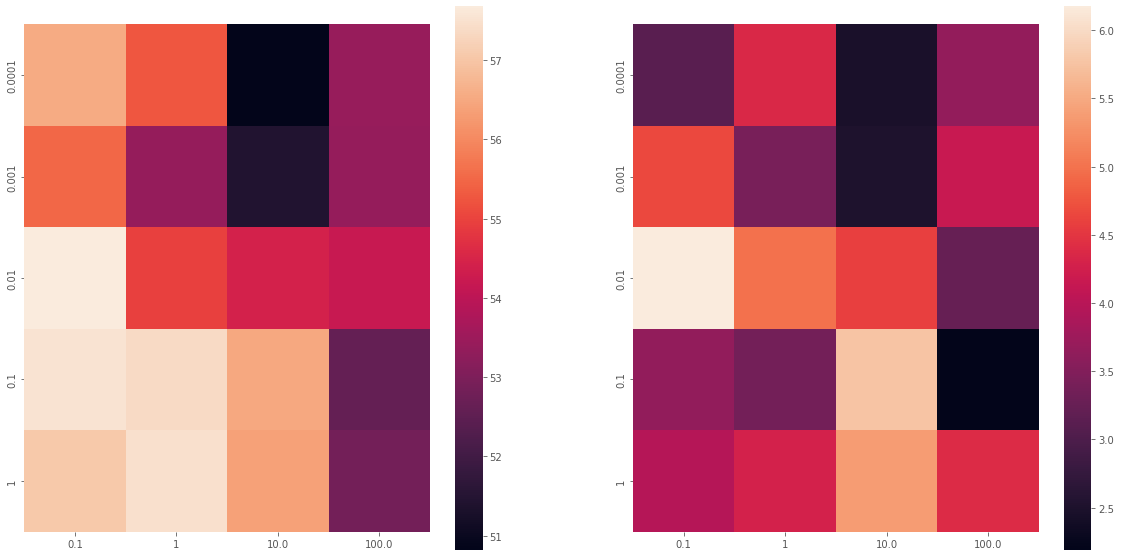

In [36]:
ear_weights = [1e-4, 1e-3, 1e-2, 1e-1, 1]
nn_weights = [1e-1, 1, 1e1, 1e2]
total_results = []
r0 = pd.read_excel(f'../Data/Results/ear_weights{ear_weights}_nn_weights{nn_weights}_cv0.xlsx', index_col=0).to_numpy()
r1 = pd.read_excel(f'../Data/Results/ear_weights{ear_weights}_nn_weights{nn_weights}_cv1.xlsx', index_col=0).to_numpy()
r2 = pd.read_excel(f'../Data/Results/ear_weights{ear_weights}_nn_weights{nn_weights}_cv2.xlsx', index_col=0).to_numpy()
r3 = pd.read_excel(f'../Data/Results/ear_weights{ear_weights}_nn_weights{nn_weights}_cv3.xlsx', index_col=0).to_numpy()

for i in range(len(ear_weights)):
    for j in range(len(nn_weights)):
        total_results.append([r0[i, j], r1[i, j], r2[i, j], r3[i, j]])


res = np.reshape(np.array(total_results), newshape=(r0.shape[0], r0.shape[1], 4))

means = np.mean(res, axis=2)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True, xticklabels=nn_weights, yticklabels=ear_weights)
stds = np.std(res, axis=2)
sns.heatmap(stds, ax=axes[1], square=True, xticklabels=nn_weights, yticklabels=ear_weights)
print(means)

# print('Min: ', np.min(means))
# min_index = np.argmin(means)
# k, r = ks_and_rs[min_index]
# print(k, r)

1, 1e-4, 10
56.5464 55.2531 50.8195 53.416 
55.4892 53.3755 51.423  53.3749
57.6814 54.9511 54.4302 54.173 
57.5447 57.3671 56.4885 52.589 
57.0387 57.491  56.3855 52.8524




85.4228
85.1202
74.1119
61.3325
59.9948

In [ ]:


# for cv_index in range(4):
#     try:
#         data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
#         train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
#         bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
#     except:
#         data = create_data(cv_index)
#     # train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
#     run_parallel_rules(data, cv_index)

    # test_hyperparameters_pair_scores(data, cv_index, deltas=deltas, gammas=gammas)
    # test_hyperparameters(data, cv_index, parallel_rules=True)

In [ ]:

total_results = []
r0 = pd.read_excel(f'../Data/Results/ear_good_pair_scores_gamma{gammas}_delta{deltas}_k4_cv0.xlsx', index_col=0).to_numpy()
r1 = pd.read_excel(f'../Data/Results/ear_good_pair_scores_gamma{gammas}_delta{deltas}_k4_cv1.xlsx', index_col=0).to_numpy()
r2 = pd.read_excel(f'../Data/Results/ear_good_pair_scores_gamma{gammas}_delta{deltas}_k4_cv2.xlsx', index_col=0).to_numpy()
r3 = pd.read_excel(f'../Data/Results/ear_good_pair_scores_gamma{gammas}_delta{deltas}_k4_cv3.xlsx', index_col=0).to_numpy()

gammas_and_deltas = []
for i in range(r0.shape[0]):
    for j in range(r0.shape[1]):
        gammas_and_deltas.append((gammas[i], deltas[j]))
        total_results.append([r0[i,j], r1[i,j], r2[i,j], r3[i,j]])
res = np.reshape(np.array(total_results), newshape=(r0.shape[0], r0.shape[1], 4))
means = np.mean(res, axis=2)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True)
stds = np.std(res, axis=2)
sns.heatmap(stds, ax=axes[1], square=True)
print(means)

print('Min: ', np.min(means))
min_index = np.argmin(means)
gamma, delta = gammas_and_deltas[min_index]
print(gamma, delta)

NameError: name 'gammas' is not defined

In [ ]:
ks = [int(k) for k in np.linspace(2, 14, 4)]
print(ks)
rs = [1e-5, 5e-5, 2.5e-4, 1.25e-3, 6.25e-3, 3.125e-2, 1.5625e-1, 7.8125e-1, 3.90625]
rs = [0.1, 0.5, 1, 5, 10]
# for cv_index in tqdm(range(4)):
#     try:
#         data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
#         train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
#         bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
#     except:
#         data = create_data(cv_index)
    
#     test_hyperparameters_k_r(data, cv_index, ks=ks, rs=rs, gamma=gamma, delta=delta)

[2, 6, 10, 14]


[[65.7891 65.0846 65.4912 65.5664]
 [65.7891 65.0846 65.4912 65.5664]
 [65.7891 65.0846 65.4912 65.5664]]
Min:  65.0846
6 6


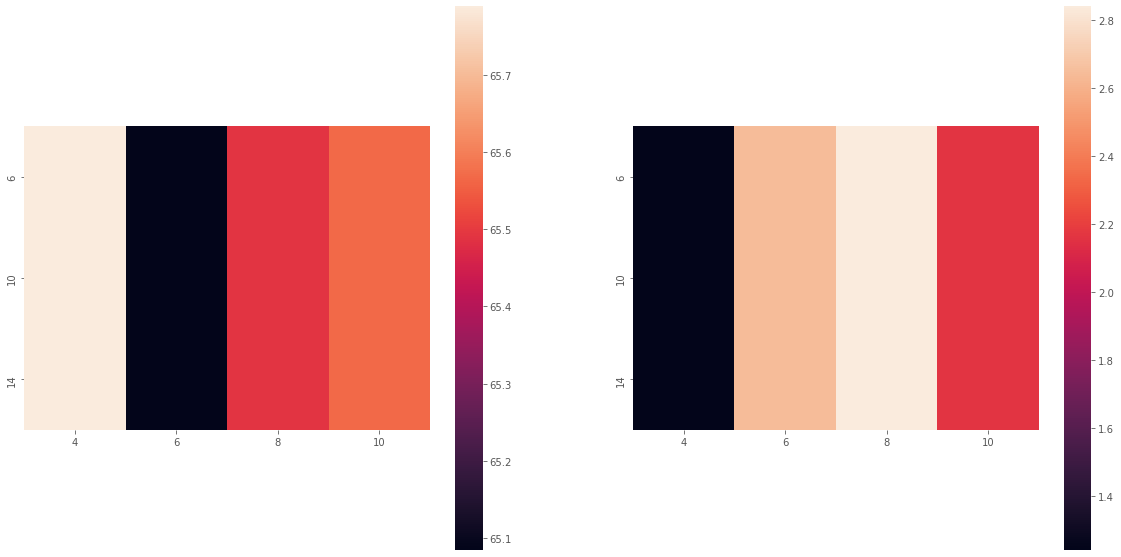

In [ ]:
total_results = []
r0 = pd.read_excel(f'../Data/Results/ks{ks}rs{rs}_cv0.xlsx', index_col=0).to_numpy()
r1 = pd.read_excel(f'../Data/Results/ks{ks}rs{rs}_cv1.xlsx', index_col=0).to_numpy()
r2 = pd.read_excel(f'../Data/Results/ks{ks}rs{rs}_cv2.xlsx', index_col=0).to_numpy()
r3 = pd.read_excel(f'../Data/Results/ks{ks}rs{rs}_cv3.xlsx', index_col=0).to_numpy()

ks_and_rs = []
for i in range(r0.shape[0]):
    for j in range(r0.shape[1]):
        ks_and_rs.append((ks[i], rs[j]))
        total_results.append([r0[i,j], r1[i,j], r2[i,j], r3[i,j]])
res = np.reshape(np.array(total_results), newshape=(r0.shape[0], r0.shape[1], 4))
means = np.mean(res, axis=2)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True, xticklabels=rs, yticklabels=ks)
stds = np.std(res, axis=2)
sns.heatmap(stds, ax=axes[1], square=True, xticklabels=rs, yticklabels=ks)
print(means)

print('Min: ', np.min(means))
min_index = np.argmin(means)
k, r = ks_and_rs[min_index]
print(k, r)

In [ ]:
parallel_weights = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4]
gamma = 1.6
delta = 3.5
k = 6
r = 6 
for cv_index in tqdm(range(4)):
    try:
        data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
        bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
    except:
        data = create_data(cv_index)
    
    test_hyperparameters_parallel(data, cv_index, k=k, r=r, parallel_rules=True, parallel_weights=parallel_weights)

  0%|          | 0/4 [00:00<?, ?it/s]

6317
[127, 670, 2202, 2675, 3000]


 25%|██▌       | 1/4 [09:10<27:32, 550.86s/it]

Results:
[66.7952 63.9848 67.3228 62.4476 63.6752 60.78   61.5752 62.8604 62.9152
 63.0396]
6292
[138, 682, 2201, 2700, 3025]


 50%|█████     | 2/4 [18:48<18:52, 566.38s/it]

Results:
[63.112  62.4608 60.2856 59.562  60.3076 59.2756 56.7104 60.122  56.4144
 56.5344]
6946
[]


 75%|███████▌  | 3/4 [29:54<10:12, 612.26s/it]

Results:
[68.4628 69.6076 69.77   69.9616 66.5896 64.1256 65.3824 65.2744 66.058
 66.0696]
7169
[]


100%|██████████| 4/4 [41:38<00:00, 624.55s/it]

Results:
[61.9684 64.9064 64.0704 63.9452 64.1348 64.9484 66.8332 64.4188 61.5852
 62.3552]


In [ ]:
parallel_weight = 10
k = 2
r = 1
gamma = 1.6
delta = 3.5

dw = 5e4
aw = 1
p = 1e-6
c2s = [5e-3, 1e-2, 5e-2, 1e-1]

scores = defaultdict(list)
# score_path = '../Data/scores_ear_tuning_1e-9_1e6.pkl'

for cv_index in tqdm(range(4)):
    try:
        data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
        bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
    except:
        data = create_data(cv_index)
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    
    itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

    ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
                                save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

    words = vectorizer.cv.get_feature_names_out()
    word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                                train_orders, 
                                                                                words, 
                                                                                gamma=gamma,
                                                                                delta=delta)
                                                                                
    min_score = np.min([score for score in word_scores if score > 0])
    word_scores = [score if score > 0 else min_score/2 for score in word_scores]

    ear_rules = get_ear_rules(ar_rules, 
                                unique_items=list(all_unique),
                                k=k,
                                r=r, 
                                embeddings_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl', 
                                save_path=f'../../Test code/Data/Rules/ear_rules_pairs_k{k}_r{r}_cv{cv_index}_parallel{parallel_weight}.pkl', 
                                word_weights=word_scores, 
                                is_sparse=True,
                                beta=r/10,
                                parallel_rules=True,
                                parallel_weight=parallel_weight) 

    for c2 in c2s:
        train_articles = create_articles(train_supports, ar_rules=ar_rules, ear_rules=ear_rules, ar_weight=1, ear_weight=c2, nn_weight=0)
        solution = run_greedy(articles=train_articles, layout=layout, distance_weight=dw, rule_weight=1, rule_weight_for_article_scores=aw, penalty_weight=p, verbose=False, hp_tuning=False)
        average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1)

        # print('yessir')
        scores[c2].append(average_distance_travelled)

# f = open(score_path, 'wb')
# pickle.dump(scores, f)
# f.close()


  0%|          | 0/4 [00:00<?, ?it/s]

6317
[127, 670, 2202, 2675, 3000]


 25%|██▌       | 1/4 [02:03<06:09, 123.19s/it]

6292
[138, 682, 2201, 2700, 3025]


 50%|█████     | 2/4 [03:30<03:24, 102.12s/it]

6946
[]


 75%|███████▌  | 3/4 [06:45<02:24, 144.51s/it]

7169
[]


100%|██████████| 4/4 [08:09<00:00, 122.37s/it]


In [ ]:
for k in scores:
    mean = np.mean(scores[k])
    
    
    std = np.std(scores[k])
    print(f'{k}\t{mean} +- {std}')

0.005	56.2693 +- 2.3926756131995823
0.01	56.23609999999999 +- 2.4991344801750874
0.05	56.2246 +- 2.6978057231757813
0.1	58.977199999999996 +- 4.529464877885688


In [ ]:
# Stig djunglar
# Baseline
baseline_path = '../Data/HP/baseline_hp_false.pkl'
baseline = defaultdict(list)
dws  = [1e-6, 1, 1e6]
dws = [1]
for cv_index in tqdm(range(4)):
    try:
        data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
        train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
        bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')
    except:
        data = create_data(cv_index)
    for dw in dws:
        train_articles = create_articles(train_supports, ar_weight=0, ear_weight=0, nn_weight=0)
        solution = run_greedy(articles=train_articles, layout=layout, distance_weight=1e6, rule_weight=1, rule_weight_for_article_scores=1e6, penalty_weight=1e6, verbose=False, hp_tuning=False)
        average_distance_travelled = evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1)
        # print('yessir')
        baseline[dw].append(average_distance_travelled)

# f = open(baseline_path, 'wb')
# pickle.dump(baseline, f)
# f.close()

for k in baseline:
    print(f'{k} :: {np.mean(baseline[k])} +- {np.std(baseline[k])}')
    

  0%|          | 0/4 [00:00<?, ?it/s]

6317
[127, 670, 2202, 2675, 3000]


 25%|██▌       | 1/4 [00:30<01:30, 30.06s/it]

6292
[138, 682, 2201, 2700, 3025]


 50%|█████     | 2/4 [00:52<00:50, 25.48s/it]

6946
[]


 75%|███████▌  | 3/4 [01:42<00:36, 36.97s/it]

7169
[]


100%|██████████| 4/4 [02:07<00:00, 31.75s/it]

1 :: 99.8785 +- 3.193185949799981


In [ ]:
# Stig djunglar
#f.close()
d = len(dws)
a = len(aws)
p = len(ps)
mm = np.zeros((d,a,p))
sm = np.zeros((d,a,p))

for i in range(d):
    for j in range(a):
        for k in range(p):
            key = (dws[i], aws[j], ps[k])
            mm[i,j,k] = np.mean(scores[key])
            sm[i,j,k] = np.std(scores[key])



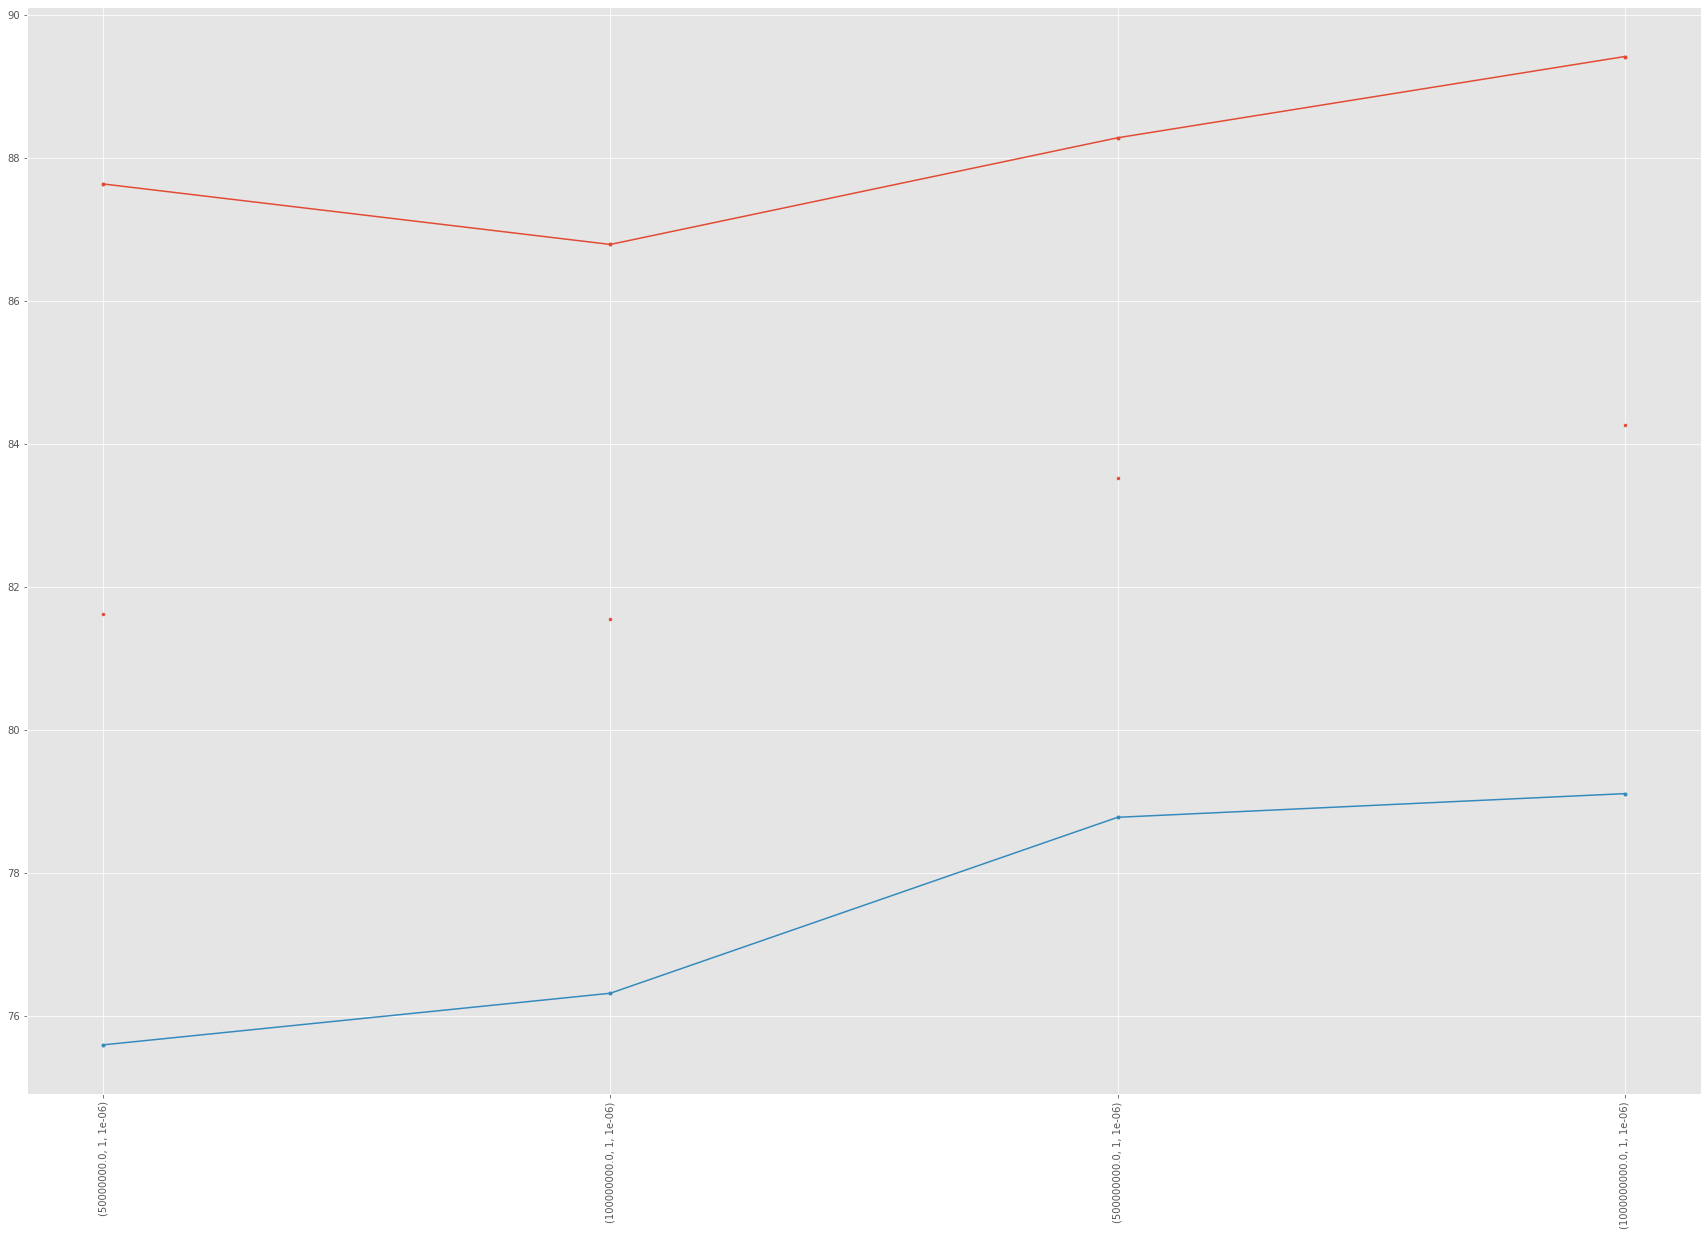

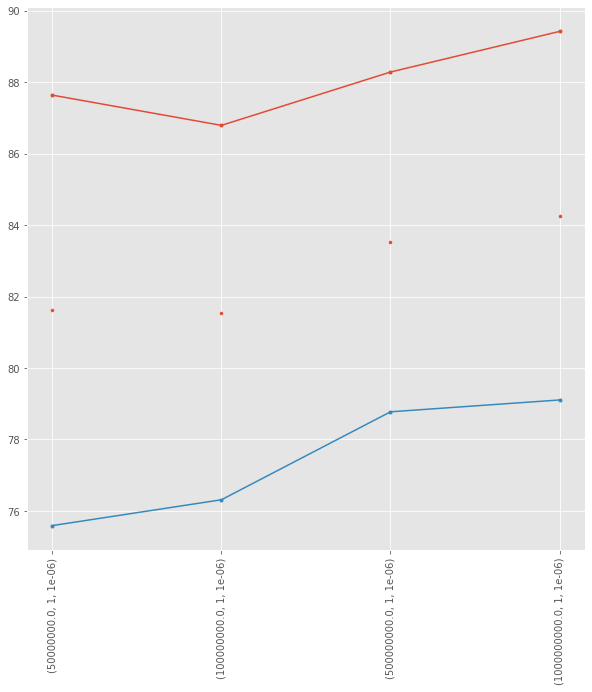

IndexError: list index out of range

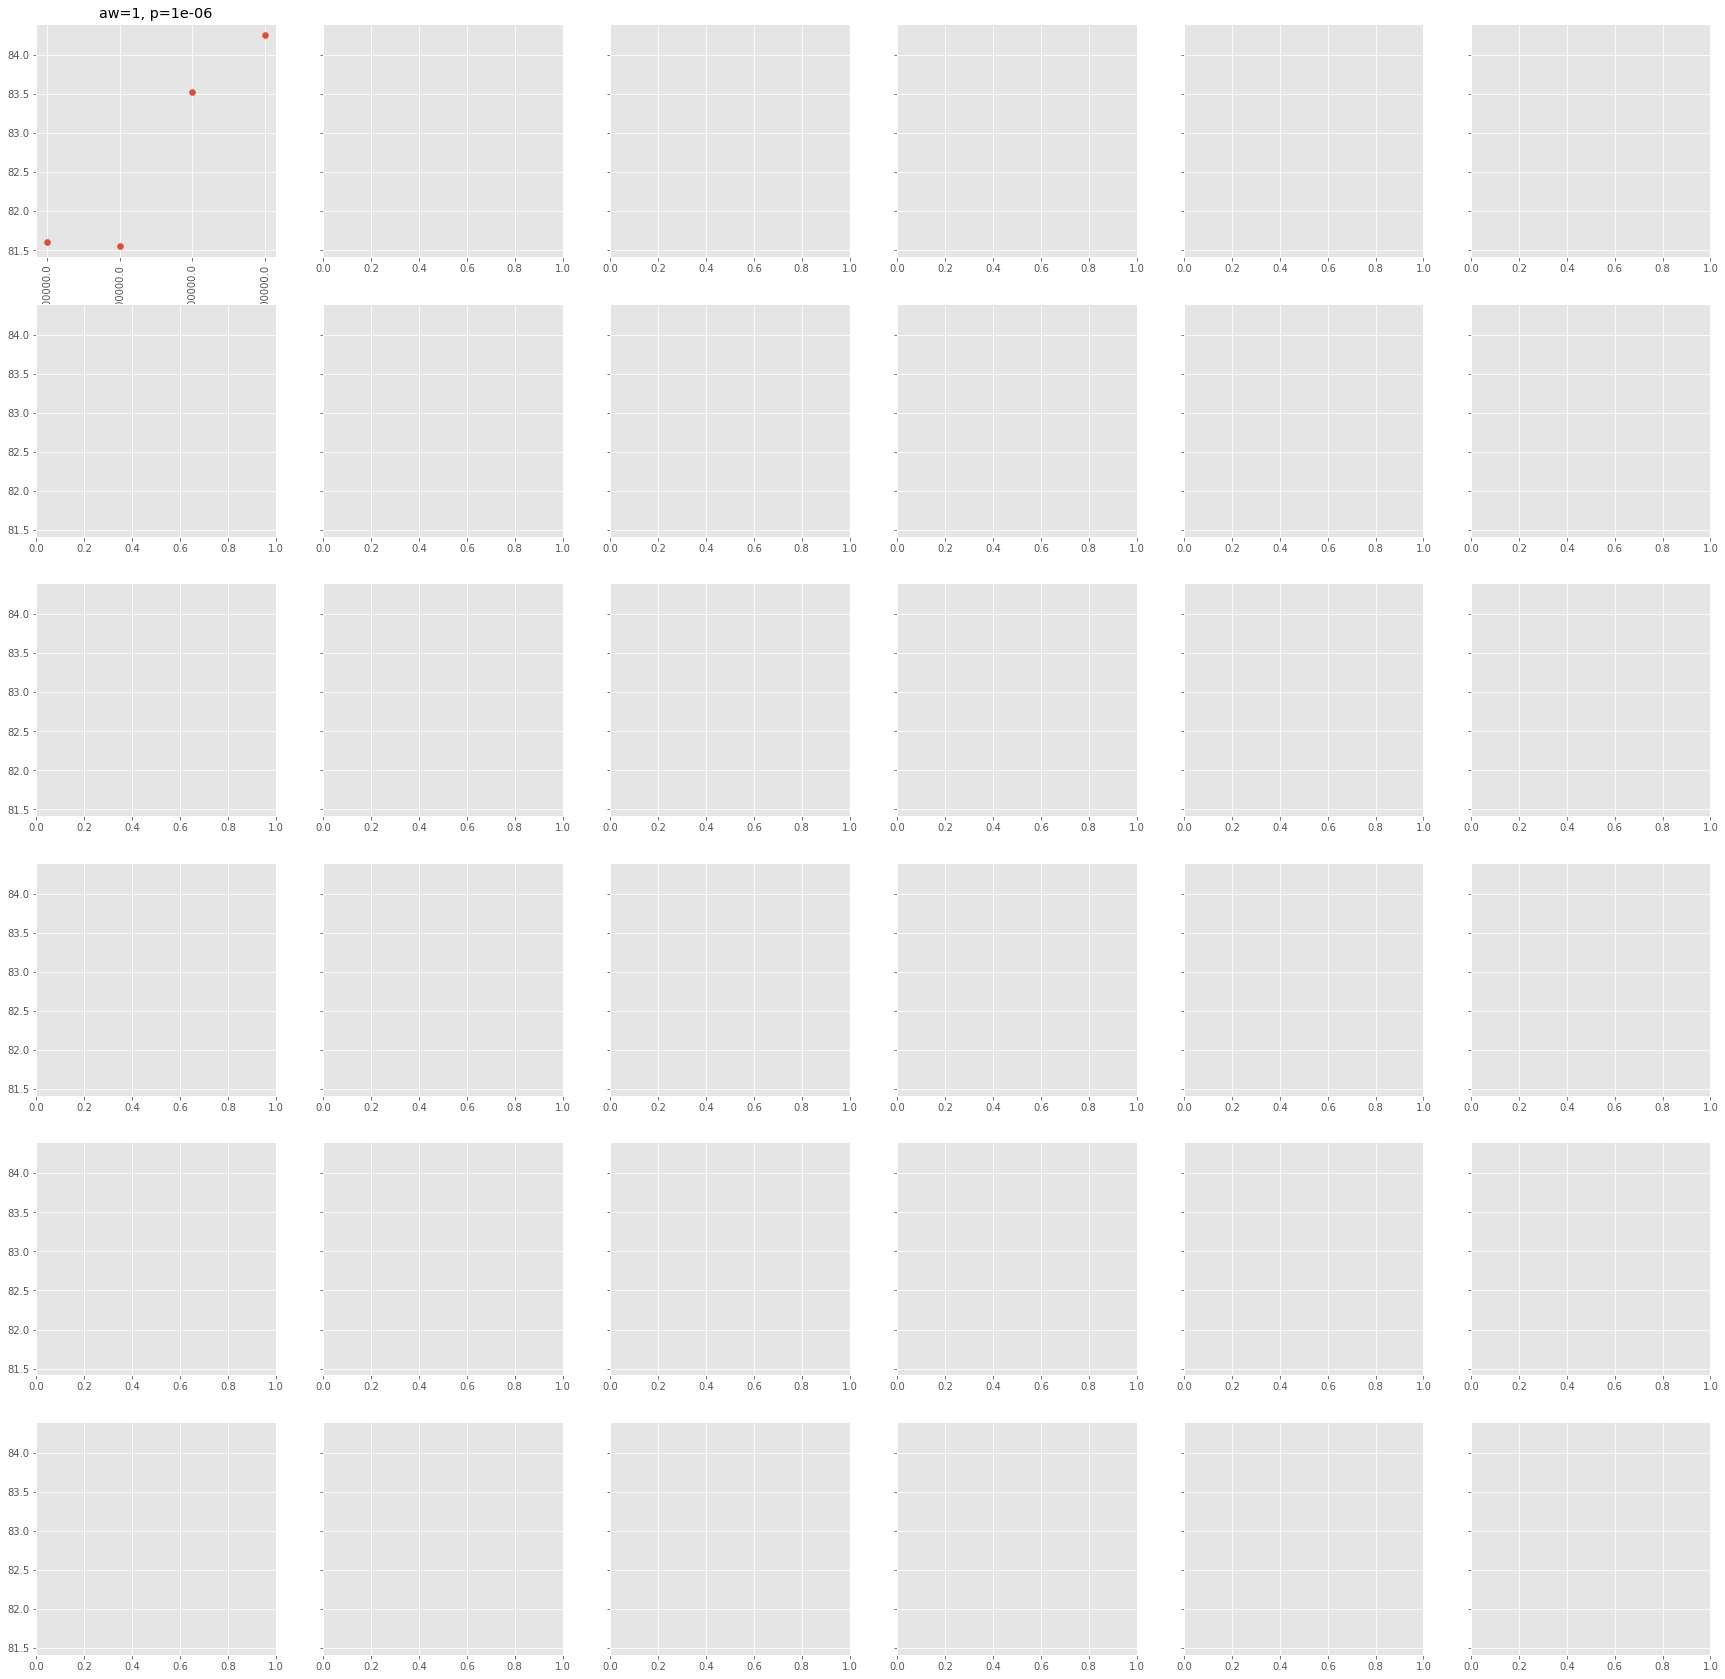

In [ ]:
# Stig djunglar
# aw >= 0.001
f = plt.figure(figsize=(30, 20))
plot_values = []
plot_stds = []
x_ticks = []
for k in scores:
    plot_values.append(np.mean(scores[k]))
    plot_stds.append(np.std(scores[k]))
    x_ticks.append(k)

plot_values = np.asarray(plot_values)
plot_stds = np.asarray(plot_stds)
plot_small = []
plot_smalls = []
s_ks = []
for i in range(len(plot_values)):
    if plot_values[i] < 90:
        plot_small.append(plot_values[i])
        plot_smalls.append(plot_stds[i])
        s_ks.append(list(scores.keys())[i])

plot_small = np.asarray(plot_small)
plot_smalls = np.asarray(plot_smalls)

plt.scatter(range(len(x_ticks)), plot_values, marker='.')
plt.plot(range(len(x_ticks)), plot_values + plot_stds, marker='.')
plt.plot(range(len(x_ticks)), plot_values - plot_stds, marker='.')
plt.xticks(range(len(x_ticks)), x_ticks, rotation=90)
plt.savefig('ear_tuning_1e-9_1e6.png', dpi=400)
plt.show()

f_small = plt.figure()
plt.scatter(range(len(s_ks)), plot_small, marker='.')
plt.plot(range(len(s_ks)), plot_small + plot_smalls, marker='.')
plt.plot(range(len(s_ks)), plot_small - plot_smalls, marker='.')
plt.xticks(range(len(s_ks)), s_ks, rotation=90)
plt.show()

f_dw, axs = plt.subplots(6,6, sharey=True, figsize=(30,30))

for i in range(d):
    for j in range(d):
        ax = axs[i,j]
        ax.set_title(f'aw={aws[i]}, p={ps[j]}')
        ax.scatter(range(d), mm[:,i,j])
        plt.sca(ax)
        plt.xticks(range(d), dws, rotation=90)
plt.show()


In [ ]:
for parallel_weight in parallel_weights:
    f = open(f'../../Test code/Data/Rules/ear_rules_single_scores_k{k}_r{r}_cv{0}_parallel{parallel_weight}.pkl', 'rb')
    rules = pickle.load(f)
    f.close()
    print(list(rules.items())[0])

('samsung galaxy s10 s10 plus kameraglas svart', defaultdict(<class 'list'>, {'samsung galaxy s10 s10 plus tejp kameralins': [0.0], 'samsung galaxy s10 s10 plus kameraglas svart': [982.0258462713592, 982.025846271359], 'copter screenprotector samsung galaxy s10 plus': [973.387030953936], 'copter exoglass curved skärmskydd samsung gala': [222.97189145482534]}))
('samsung galaxy s10 s10 plus kameraglas svart', defaultdict(<class 'list'>, {'samsung galaxy s10 s10 plus tejp kameralins': [0.10704285714285716], 'samsung galaxy s10 s10 plus kameraglas svart': [982.0258462713592, 982.025846271359], 'copter screenprotector samsung galaxy s10 plus': [973.387030953936], 'copter exoglass curved skärmskydd samsung gala': [222.97189145482534]}))
('samsung galaxy s10 s10 plus kameraglas svart', defaultdict(<class 'list'>, {'samsung galaxy s10 s10 plus tejp kameralins': [1.0704285714285715], 'samsung galaxy s10 s10 plus kameraglas svart': [982.0258462713592, 982.025846271359], 'copter screenprotector 

# Oklart

In [ ]:
n_orders=20000
average_distance_travelled = 0
for cv_index in tqdm(range(4)):
    data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{cv_index}.pkl')
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    bow = vectorizer.get_sparse_bow_embeddings(list(all_unique), save_path=f'../Data/sparse_bow_{n_orders}_cv{cv_index}.pkl')  
    train_articles = create_articles(train_supports, ar_weight=0, ear_weight=0, nn_weight=0)
    solution = run_greedy(articles=train_articles, layout=layout, distance_weight=1, rule_weight=0, rule_weight_for_article_scores=0, penalty_weight=0, verbose=False, hp_tuning=False)
    average_distance_travelled += evaluate_solution_for_greedy(solution, test_df, layout, batch_size=1, verbose=False)
print(average_distance_travelled/4)


  0%|          | 0/4 [00:00<?, ?it/s]

6317
[127, 670, 2202, 2675, 3000]


 25%|██▌       | 1/4 [00:29<01:28, 29.57s/it]

6292
[138, 682, 2201, 2700, 3025]


 50%|█████     | 2/4 [00:48<00:47, 23.52s/it]

6946
[]


 75%|███████▌  | 3/4 [01:34<00:33, 33.70s/it]

7169
[]


100%|██████████| 4/4 [01:56<00:00, 29.01s/it]

99.94109999999999


# Plots

[[70.7999 70.7999 70.7999 70.7999 70.7999 70.7999 70.7999 70.7999 70.7999]
 [70.5585 71.7893 71.8099 71.097  70.8741 70.5838 70.2296 70.1362 69.9008]
 [71.3666 71.1496 70.8482 70.73   69.3102 69.9579 67.6261 65.8809 64.9763]
 [70.7778 71.0942 70.235  69.538  68.4947 65.811  63.3768 62.5292 63.9912]
 [70.5571 71.0108 69.6682 67.2103 63.706  63.3241 63.8973 62.792  66.4889]
 [71.162  70.8438 69.9104 64.3365 63.1833 63.0839 63.561  65.1108 66.5861]
 [71.4201 70.1837 67.3436 64.6505 63.7281 63.4825 66.5318 66.7151 67.7487]
 [71.1478 70.2821 64.3565 64.701  62.6935 65.6052 67.3527 67.6614 68.2119]
 [71.0534 69.9921 64.975  66.073  64.7294 67.2683 68.099  67.7384 67.5627]]


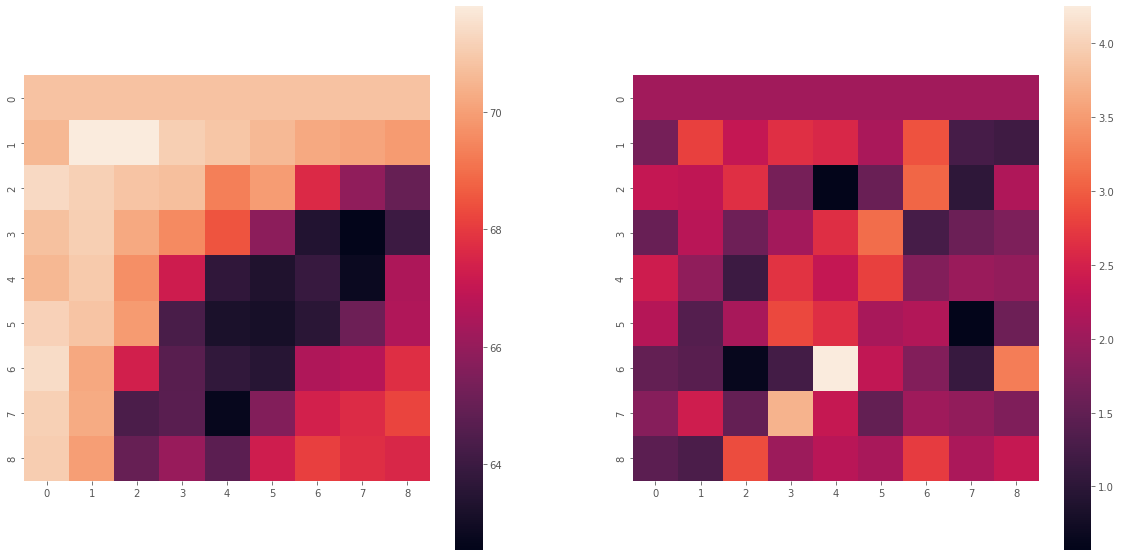

In [ ]:
# Optimal values: gamma = 0.75, delta = 1.75! (equivalent to only gamma = 1.3125...)
# k = 4, beta = 0.01, gamma and delta between 0 and 2, single_word_scores
total_results = []
r0 = pd.read_excel(f'../Data/Results/ear_gamma{np.linspace(0,2,9)}_delta{np.linspace(0,2,9)}_k4_cv0.xlsx', index_col=0).to_numpy()
r1 = pd.read_excel(f'../Data/Results/ear_gamma{np.linspace(0,2,9)}_delta{np.linspace(0,2,9)}_k4_cv1.xlsx', index_col=0).to_numpy()
r2 = pd.read_excel(f'../Data/Results/ear_gamma{np.linspace(0,2,9)}_delta{np.linspace(0,2,9)}_k4_cv2.xlsx', index_col=0).to_numpy()
r3 = pd.read_excel(f'../Data/Results/ear_gamma{np.linspace(0,2,9)}_delta{np.linspace(0,2,9)}_k4_cv3.xlsx', index_col=0).to_numpy()

for i in range(r0.shape[0]):
    for j in range(r0.shape[1]):
        total_results.append([r0[i,j], r1[i,j], r2[i,j], r3[i,j]])
res = np.reshape(np.array(total_results), newshape=(r0.shape[0], r0.shape[1], 4))
means = np.mean(res, axis=2)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True)
stds = np.std(res, axis=2)
stds[8, 3] =2
sns.heatmap(stds, ax=axes[1], square=True)
print(means)


[[63.4145 63.4895 62.5935 63.8645 63.8025]
 [64.8182 64.3536 63.8962 64.5184 64.1444]
 [64.8182 64.3536 63.8962 64.5184 64.1444]
 [64.8182 64.3536 63.8962 64.5184 64.1444]]


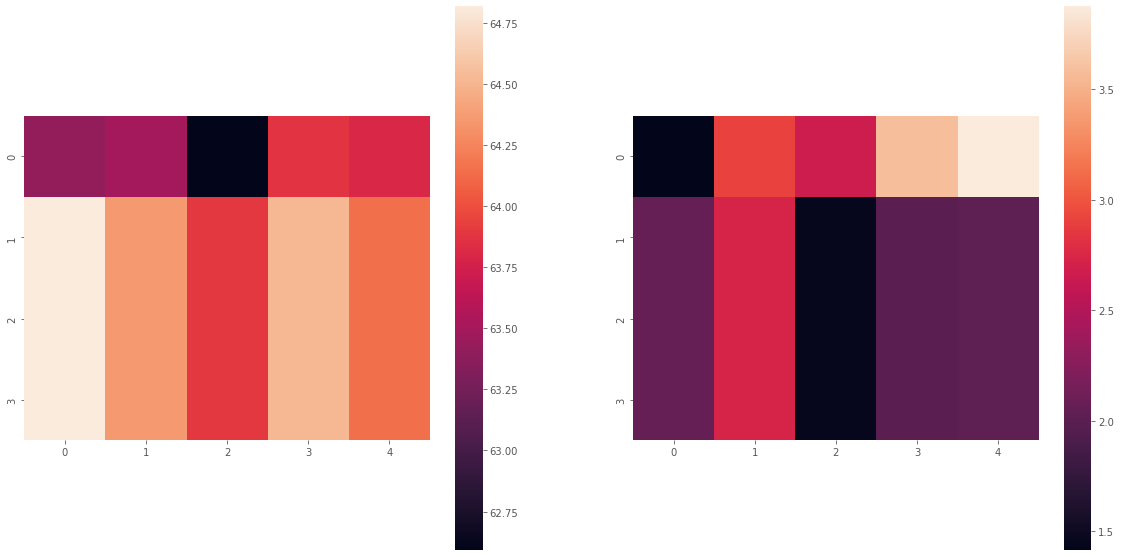

In [ ]:
total_results = []
r0 = pd.read_excel(f'../Data/Results/ear_k{ks}_r{rs}_k4_cv0.xlsx', index_col=0).to_numpy()
r1 = pd.read_excel(f'../Data/Results/ear_k{ks}_r{rs}_k4_cv1.xlsx', index_col=0).to_numpy()
r2 = pd.read_excel(f'../Data/Results/ear_k{ks}_r{rs}_k4_cv2.xlsx', index_col=0).to_numpy()
r3 = pd.read_excel(f'../Data/Results/ear_k{ks}_r{rs}_k4_cv3.xlsx', index_col=0).to_numpy()

for i in range(r0.shape[0]):
    for j in range(r0.shape[1]):
        total_results.append([r0[i,j], r1[i,j], r2[i,j], r3[i,j]])
res = np.reshape(np.array(total_results), newshape=(r0.shape[0], r0.shape[1], 4))
means = np.mean(res, axis=2)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True)
stds = np.std(res, axis=2)
# stds[8, 3] =2
sns.heatmap(stds, ax=axes[1], square=True)
print(means)


[[70.4813 70.3094 70.1503 71.2913 69.9583 69.9987 70.689  70.6798]
 [70.9524 69.5104 69.9898 70.1437 70.1902 67.7766 67.7032 66.361 ]
 [70.4038 69.521  69.9359 69.084  66.957  66.1699 64.8578 64.3817]
 [69.9314 70.9489 69.6698 66.0768 64.4484 64.7803 63.3869 65.6373]
 [69.4307 69.7765 65.9676 63.2132 63.866  64.9465 65.6554 64.3317]
 [69.5976 69.5187 66.0927 64.1071 64.6812 64.979  64.0041 65.6653]
 [70.459  67.6103 64.3229 64.5008 65.5307 63.7385 63.9462 65.0745]
 [70.2339 66.1696 63.8068 64.8288 64.5171 65.1245 65.3504 65.1459]]


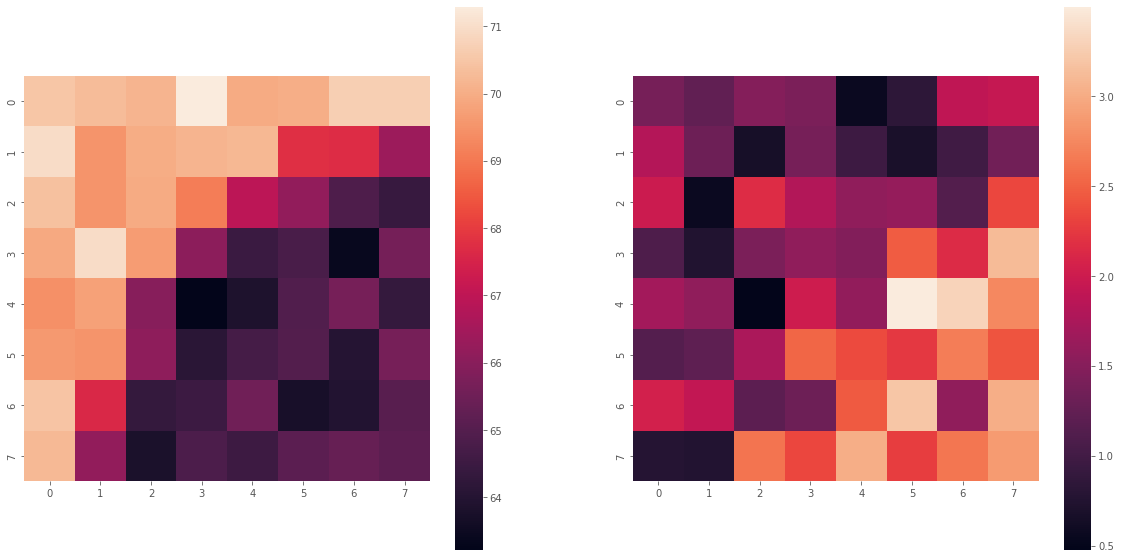

In [ ]:
total_results = []
r0 = pd.read_excel(f'../Data/Results/ear_pair_scores_gamma[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]_delta[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]_k4_cv0.xlsx', index_col=0).to_numpy()
r1 = pd.read_excel(f'../Data/Results/ear_pair_scores_gamma[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]_delta[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]_k4_cv1.xlsx', index_col=0).to_numpy()
r2 = pd.read_excel(f'../Data/Results/ear_pair_scores_gamma[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]_delta[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]_k4_cv2.xlsx', index_col=0).to_numpy()
r3 = pd.read_excel(f'../Data/Results/ear_pair_scores_gamma[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]_delta[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]_k4_cv3.xlsx', index_col=0).to_numpy()

for i in range(r0.shape[0]):
    for j in range(r0.shape[1]):
        total_results.append([r0[i,j], r1[i,j], r2[i,j], r3[i,j]])
res = np.reshape(np.array(total_results), newshape=(r0.shape[0], r0.shape[1], 4))
means = np.mean(res, axis=2)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.heatmap(means, ax=axes[0], square=True)
stds = np.std(res, axis=2)
# stds[8, 3] =2
sns.heatmap(stds, ax=axes[1], square=True)
print(means)

ValueError: The number of FixedLocator locations (64), usually from a call to set_ticks, does not match the number of ticklabels (42).

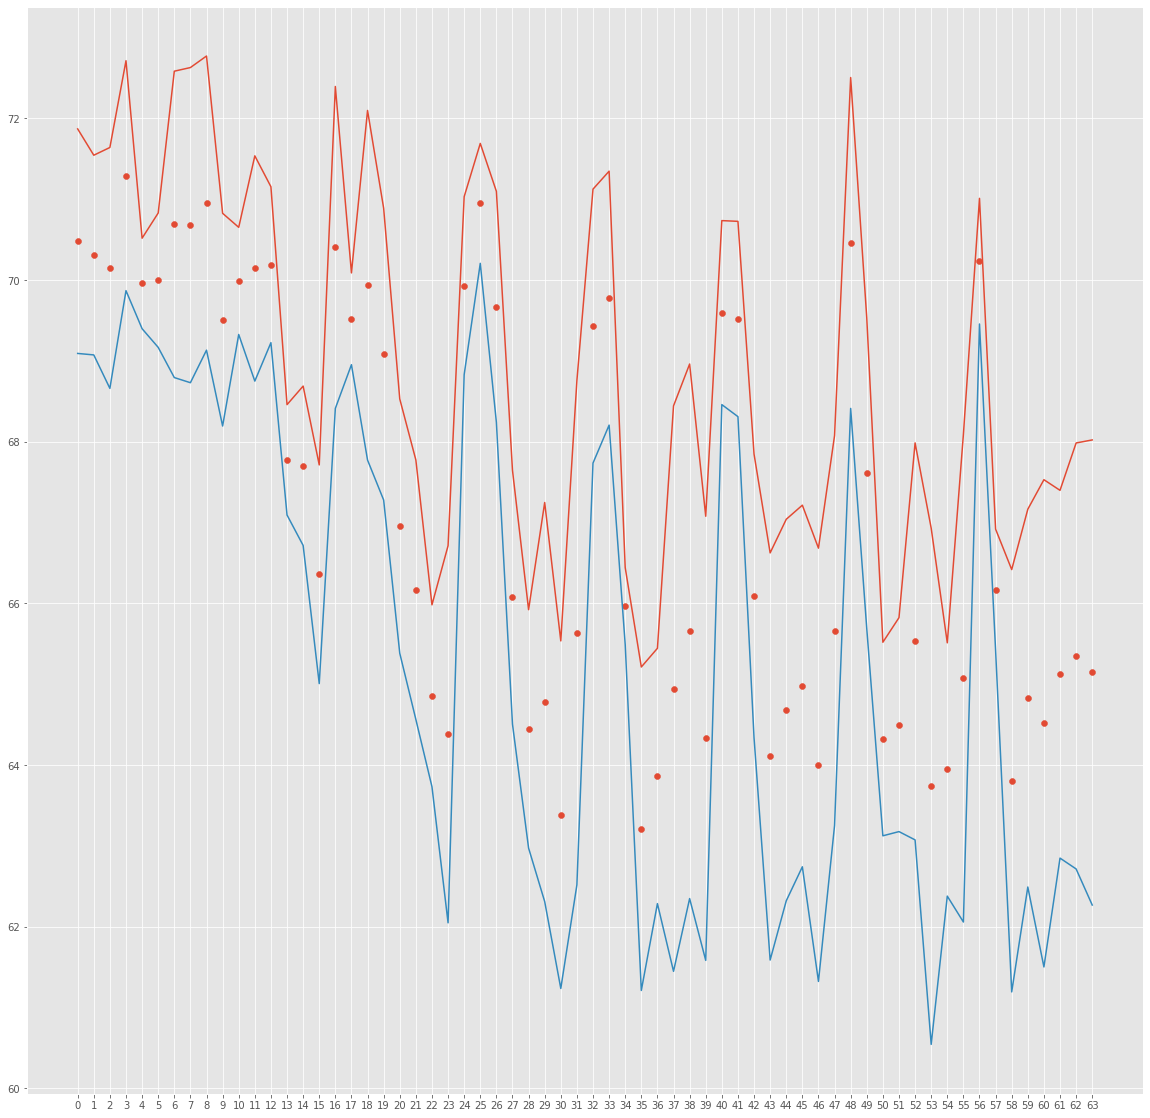

In [ ]:
length = means.shape[0]*means.shape[1]
f = plt.figure(1, figsize=(20, 20))
plt.scatter(np.arange(length), means)
plt.plot(np.arange(length), np.reshape(means + stds, -1))
plt.plot(np.arange(length), np.reshape(means - stds, -1))

ticks = []
for gamma in gammas:
    for delta in deltas:
        ticks.append(str(gamma) + ', ' + str(delta))
plt.xticks(np.arange(length), ticks, rotation=90)
plt.show()

In [ ]:
gamma = 1e-15
delta = 1e-15
train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
words = vectorizer.cv.get_feature_names_out()
word_scores, single_word_scores, word_frequencies = calculate_word_scores(train_unique, 
                                                                          train_orders, 
                                                                          words, 
                                                                          gamma=gamma,
                                                                          delta=delta)
print(np.mean(word_scores))

582306.9999999949


In [ ]:
# f = open('../Data/sparse_bow_20000_cv0.pkl', "rb")
# bow = pickle.load(f)
# f.close()

for i in range(4):
    data = load_data(f'../../Test code/Data/{n_orders}_orders/data_{i}.pkl')
    train_df, test_df, train_supports, train_unique, all_unique, train_orders, vectorizer = data
    print(train_df.shape)
# print(train_df)
# print(test_df)
# print(len(bow.keys()))
# print(bow.keys())
# for w in bow['skal stativ huawei p30 pro transparent']:
#     print(words[w])
# print(single_word_scores[1728], single_word_scores[2533], single_word_scores[2675])
# print(single_word_scores[2960], single_word_scores[3095], single_word_scores[3320])
# print(np.std(single_word_scores))
# print(len(np.unique(single_word_scores)))

(15000, 6317)
(15000, 6292)
(15000, 6946)
(15000, 7169)


In [ ]:

# print(ar_rules['skal stativ huawei p30 pro transparent'])

save_path = '../../Test code/Data/Rules/ear_rules_k4_unweighted_cv0.pkl'
f = open(save_path, "rb")
ear_rules = pickle.load(f)
f.close()
print(ear_rules['iphone _7_ skärm lcd display vit'])

# itemsets, itemsets_size_2 = generate_itemsets(train_df, min_support=0.0001)

# ar_rules = compute_ar_rules(itemsets_size_2, metric='lift', min_threshold=1, 
#                             save_path=f'../Data/Rules/ar_rules_{n_orders}_cv{cv_index}.pkl')

# print(ar_rules['iphone _7_ skärm lcd display vit'])
# print(train_df.columns[:100])

# gamma = 1/2
# delta = 2.0
# save_path = f'../../Test code/Data/Rules_04_28/ear_rules_single_scores_k4_gamma{gamma}_delta{delta}_2.pkl'
# f = open(save_path, "rb")
# ear_rules = pickle.load(f)
# f.close()
# print(ear_rules['skal stativ huawei p30 pro transparent'])

# gamma = 1.0
# delta = 2.0
# save_path = f'../../Test code/Data/Rules_04_28/ear_rules_single_scores_k4_gamma{gamma}_delta{delta}_2.pkl'
# f = open(save_path, "rb")
# ear_rules = pickle.load(f)
# f.close()
# print(ear_rules['skal stativ huawei p30 pro transparent'])

FileNotFoundError: [Errno 2] No such file or directory: '../../Test code/Data/Rules/ear_rules_k4_unweighted_cv0.pkl'

### Parallel rules visualization


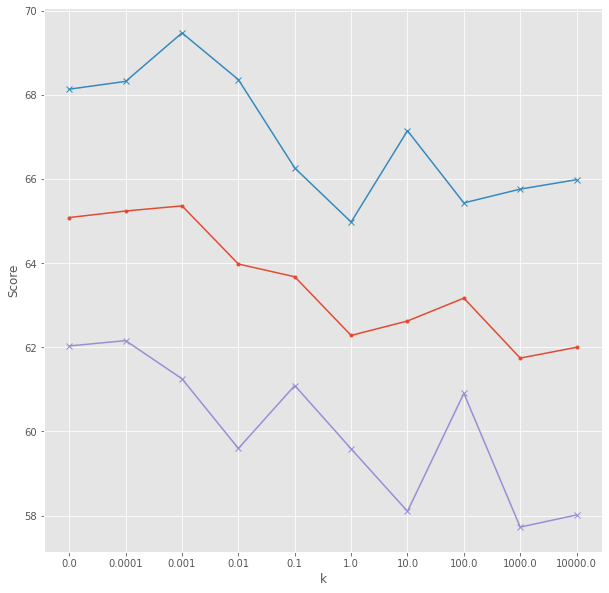

In [ ]:
scores = np.zeros((len(parallel_weights),))
stds = np.zeros((len(parallel_weights),))
total_df = pd.DataFrame(columns=['k', 'score_0', 'score_1', 'score_2', 'score_3'])
for i in range(4):
    df = pd.read_excel(f'../Data/Results/ear_k_parallel{parallel_weights}_cv{i}.xlsx')
    df.columns = ['k', f'score_{i}']
    total_df.loc[:, 'k'] = df['k']
    total_df.loc[:, f'score_{i}'] = df[f'score_{i}']


sns_df = total_df.copy(deep=True)

total_df.index=total_df['k']
total_df.drop(labels='k', axis=1, inplace=True)

mean_scores = total_df.mean(axis=1)
stds = total_df.std(axis=1)

f = plt.figure()

plt.plot(range(len(mean_scores)), mean_scores, marker='.')
plt.plot(range(len(mean_scores)), mean_scores + stds, marker='x')
plt.plot(range(len(mean_scores)), mean_scores - stds, marker='x')

plt.xticks(range(len(mean_scores)), df['k'])
plt.xlabel('k')
plt.ylabel('Score')

plt.show()
